# INDENG 243 &nbsp; Project - Module 2

## *GoodReads*: Book Analytics & Recommendation System

- @Group: 18
---

## Agenda

- Model Data Preparation
- Recommendation models
    - Popularity Model (Baseline)
    - Content-based Filtering
    - Collaborative Filtering
    - Hybrid Model
- NLP Model
    - Tag filtering system
    - Extractive summarization
- Summay & Future plans

## Part 1) &nbsp; Model data preparation

In [1]:
import pandas as pd
import numpy as np

df_original = pd.read_csv('./Datasets/Book_info_original.csv')

### 1.1 &nbsp; Data Revise

#### In previous exploratory data analysis, we observed some potential flaws in original datasets:

#### 1.1 &nbsp; Insufficient *manga* books

- Books under genre ***manga*** seems being especially insufficient in data (only 20 books) compared to other genres (100\~300 books)

In [10]:
len(df_original[df_original['Genre'] == 'manga'])

20

#### 1.2 &nbsp; Hidden duplicated books

- Interestingly, some books are implicitly duplicated in original data: they only differ in `Genre` but all these records refer to a same book;
- The resaon is that in our previous web scraping, for simplicity we keep the pre-defined 40 genres as the main `Genre` attribute for each book, but sometimes a single book will be listed under many different genres, resulting in *'duplicated'* records.
    - E.g. See the following *Harry Potter and the Chamber of Secrests*, it actually was listed under fantasy, fiction, children, etc
<br></br>
- However, these implicit duplicates are not detected by codes directly using ***.duplicated()***

In [12]:
# if directly using .duplicated() to detect duplicates
df_original.duplicated().sum()

0

In [15]:
df_original[df_original['Uid'] == 15881].head(4)

Uid                                    Title        Author  \
974   15881  Harry Potter and the Chamber of Secrets  J.K. Rowling   
2509  15881  Harry Potter and the Chamber of Secrets  J.K. Rowling   
2671  15881  Harry Potter and the Chamber of Secrets  J.K. Rowling   
2869  15881  Harry Potter and the Chamber of Secrets  J.K. Rowling   

           Genre                                         Sub_Genres  Rating  \
974   children-s  ['Fiction', 'Young Adult', 'Magic', 'Childrens...    4.43   
2509      ebooks  ['Fiction', 'Young Adult', 'Magic', 'Childrens...    4.43   
2671     fantasy  ['Fiction', 'Young Adult', 'Magic', 'Childrens...    4.43   
2869     fiction  ['Fiction', 'Young Adult', 'Magic', 'Childrens...    4.43   

      Publish_Date  Page_Num  \
974   July 2, 1998       341   
2509  July 2, 1998       341   
2671  July 2, 1998       341   
2869  July 2, 1998       341   

                                                  Award  \
974   ['Mythopoeic Fantasy Award', 'British Book Awa...   
2509  ['Mythopoeic Fantasy Award', 'British Book Awa...   
2671  ['Mythopoeic Fantasy Award', 'British Book Awa...   
2869  ['Mythopoeic Fantasy Award', 'British Book Awa...   

                                            Description  \
974   Ever since Harry Potter had come home for the ...   
2509  Ever since Harry Potter had come home for the ...   
2671  Ever since Harry Potter had come home for the ...   
2869  Ever since Harry Potter had come home for the ...   

                                            Author_Desc Book_Authored  \
974   See also: Robert GalbraithAlthough she writes ...           402   
2509  See also: Robert GalbraithAlthough she writes ...           403   
2671  See also: Robert GalbraithAlthough she writes ...           403   
2869  See also: Robert GalbraithAlthough she writes ...           403   

     Follower_Num  Review_Num  Rating_Num  \
974          221k       69407     3521877   
2509         221k       69413     3522124   
2671         221k       69415     3522180   
2869         221k       69415     3522180   

                                            Rating_Dist  
974   ['2089806 (59%)', '962935 (27%)', '382971 (10%...  
2509  ['2089955 (59%)', '963001 (27%)', '382992 (10%...  
2671  ['2089984 (59%)', '963023 (27%)', '382996 (10%...  
2869  ['2089984 (59%)', '963023 (27%)', '382996 (10%...

Subsequently this observatin gives a rise to other fundamental problems: 
- 1) ***Which of these duplicated records should we keep?*** (i.e. Which genre you think these books should be?)
    - It is hard to answer because a book's content might interact with many different genres and randomly keeping one record is unreasonable;
    - So we decided to obtain each book's genre list by re-scrape it under book's information page, rather than genre classification given by website
<br></br>
- 2) If we drop the duplicates, the number of unique books are greatly reduced (8032 --> 5545)

In [116]:
print("The original total book number is: ", len(df_original))
print("The unique book number is: ", len(df_original.drop_duplicates(subset=['Uid', 'Title'])))

The original total book number is:  8032
The unique book number is:  5545


#### 1.3 &nbsp; Biased reviews

- Review dataset might be biased: more positive reviews than negative ones (feedback from Module 1)
- Currently  # **Negative** review (Rating: 1\~3) : # **Positive** review (Rating: 4\~5) = **1 : 4** (roughly), unbalanced

#### To solve the above problems, we decide to re-scrape additional book data, which is in nature the best and straightforward solution

The revised dataset has the following improvements targeting previous probems:
- More *manga* books: 20 --> 140
- Re-scrape the book genre list: see detailed code in `Uid_Genre.py`
- Re-scrape more unique books, 5545 --> 7846 (`Genre_Book_Add.py`)
- Correspondingly more book reviews: 80461 --> 115033 and we purposely select more negative reviews to make dataset more balanced
    -  \# **Negative** review (Rating: 1\~3) : \# **Positive** review (Rating: 4~5) = **1 : 2** (more balanced compared to before)

For data combination, cleansing and some pre-processing steps, since they are lengthy and not close to this module's topic, you can see detailed codes in [Data_Revise_Cleansing.ipynb](./Data_Revise_Cleansing.ipynb) if you like. We will directly use the further cleaned datasets in following sections:
- **Book_info_cleaned.csv**
- **Book_reviews_cleaned.csv**
- **Book_stats** (folder for all book statistics, since 1 book has 4 x 170 entries, we keep them separately)

### 1.2 &nbsp; Datasets modification for model use

### 1.2.1 &nbsp; Book information dataset: `df_info` dataframe

In [16]:
df_info = pd.read_csv('./Datasets/Basic_datasets/Book_info_cleaned.csv')

In [17]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7776 entries, 0 to 7775
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Uid            7776 non-null   int64  
 1   Title          7776 non-null   object 
 2   Genres         7776 non-null   object 
 3   Author         7776 non-null   object 
 4   Rating         7776 non-null   float64
 5   Publish_Date   7776 non-null   object 
 6   Page_Num       7776 non-null   int64  
 7   Award          7776 non-null   object 
 8   Description    7761 non-null   object 
 9   Author_Desc    7116 non-null   object 
 10  Book_Authored  7776 non-null   int64  
 11  Follower_Num   7776 non-null   int64  
 12  Review_Num     7776 non-null   int64  
 13  Rating_Num     7776 non-null   int64  
 14  Five_Star      7776 non-null   int64  
 15  Four_Star      7776 non-null   int64  
 16  Three_Star     7776 non-null   int64  
 17  Two_Star       7776 non-null   int64  
 18  One_Star

#### Turn rating distribution into percentage

- Since different books have different volume of ratings number, it is more reasonable to look at the percentage of each rating category rather than the real rating number. So we first compute the rating percentages as follows:

In [18]:
df_info['Five_star_percent'] =  df_info['Five_Star'] / df_info['Rating_Num']
df_info['Four_star_percent'] =  df_info['Four_Star'] / df_info['Rating_Num']
df_info['Three_star_percent'] =  df_info['Three_Star'] / df_info['Rating_Num']
df_info['Two_star_percent'] =  df_info['Two_Star'] / df_info['Rating_Num']
df_info['One_star_percent'] =  df_info['One_Star'] / df_info['Rating_Num']

In [110]:
df_info = df_info.drop(['Five_Star', 'Four_Star', 'Three_Star', 'Two_Star', 'One_Star'], axis=1)

#### Data pre-processing before using `df_info` dataframe

- Because the list-type data are stored as *strings*, we need to turn them back to the correct data type.

In [20]:
from ast import literal_eval

df_info['Genres'] = df_info['Genres'].apply(lambda x: literal_eval(x) if "[" in x else x)
df_info['Award'] = df_info['Award'].apply(lambda x: literal_eval(x) if "[" in x else x)

#### Award - Ordinal Encoding
- We use the number of awards the book has obtained to represent the 'Award' attribute
- https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/

In [21]:
Award_Num = df_info['Award'].apply(lambda x: 0 if x == ['no'] else len(x))
df_info['Award_Num'] = Award_Num

#### We look at the book ratings' distribution

In [48]:
print("The number of low rating books (Rating <= 4.0): ", len(df_info[df_info['Rating'] < 4.0]))
print("The number of high rating books (Rating > 4.0): ", len(df_info[df_info['Rating'] >= 4.0]))

The number of low rating books (Rating <= 4.0):  2992
The number of high rating books (Rating > 4.0):  4784


#### Book Statistics

The book statistics data reflects the ***changes*** (compared to previous day) in the following attributes over past 6 months:
- **date**: The date for these statistics
- **added**: changes of times this book has been added to users' bookshelves from previous day
- **ratings**: changes of times this book has been rated by users from previous day
- **reveiws**: changes of times this book is left reviews by users from previous day
- **to-read**: changes of times this book has been marked as 'to-read' by users

(*Note: the first row in file is the sum of these statistics until the day we scraped the data*)

We want to combine book statistics into its information dataframe `df_info`, however, each book only has one entry in information dataframe, while it has 4 x 170 records for its statistics. Directly combining them will make the dimensionality messy and hard to interpret, so we decide to use their statistical indicators for better measurement:
- **Median**: measures the central tendency of data distribution 
- **IQR** (Interquatile Range): measures the dispersion level of data distributiion (*more robust to scale problem compared to variance*)
    - https://en.wikipedia.org/wiki/Robust_measures_of_scale

In [36]:
import os

path = './Partial_datasets/Book_stats/'
filenames = os.listdir(path)

In [60]:
df_demo = pd.read_csv(path + filenames[0])
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     172 non-null    object
 1   added    172 non-null    int64 
 2   ratings  172 non-null    int64 
 3   reviews  172 non-null    int64 
 4   to-read  172 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.8+ KB


#### Combine book statistics and compute statistical indicators simultaneously

In [38]:
df_info_stats = pd.DataFrame()

for file in filenames:
    uid = int(file.split('_stats')[0])
    stats_df = pd.read_csv(path + file)
    
    # the first line is the sum of all following statistics, so separately processing it
    data = stats_df.iloc[0, [1, 4]].astype('int64').values
    data_df = pd.DataFrame(data = [uid] + list(data), index = ['Uid', 'AddedShelf', 'ToRead'])
    
    # compute median & IQR
    stats = stats_df.iloc[1:, 1:]
    IQR_df = (stats.quantile(q=0.75) - stats.quantile(q=0.25)).add_suffix('_IQR')
    median_df = stats.median().add_suffix('_median')
    
    stats_combine = pd.concat([data_df, median_df, IQR_df]).T
    df_info_stats = pd.concat([df_info_stats, stats_combine], ignore_index=True)

In [39]:
df_info_stats[['Uid', 'AddedShelf', 'ToRead']] = df_info_stats[['Uid', 'AddedShelf', 'ToRead']].astype('int64')
df_info_stats

Uid  AddedShelf  ToRead  added_median  ratings_median  \
0       100021       13107    6471           7.0             2.0   
1     10006486        2627    1703           1.0             0.0   
2      1000751      124063   26433          24.0             7.0   
3     10008056       36918    6637          12.0             4.0   
4     10009377       27195   11902          22.0             6.0   
...        ...         ...     ...           ...             ...   
7771     99713       22569    8889           3.0             1.0   
7772       998      244540  121383         101.0            28.0   
7773     99944      192255   98182          58.0            10.0   
7774     99955       35739   18080           5.0             1.0   
7775   9999107       85198   32656          19.0             5.0   

      reviews_median  to-read_median  added_IQR  ratings_IQR  reviews_IQR  \
0                0.0             4.0       3.00         2.00          0.0   
1                0.0             1.0       1.00         0.00          0.0   
2                1.0             7.0       8.00         7.00          1.0   
3                0.0             2.0       6.00         4.75          0.0   
4                0.0             9.0      17.75         5.00          1.0   
...              ...             ...        ...          ...          ...   
7771             0.0             2.0       3.00         1.00          0.0   
7772             1.0            59.0      39.00        12.00          2.0   
7773             1.0            35.0      18.00         7.00          1.0   
7774             0.0             3.0       2.50         1.00          0.0   
7775             0.0             7.0       7.75         5.00          1.0   

      to-read_IQR  
0             2.5  
1             2.0  
2             4.0  
3             2.0  
4             8.0  
...           ...  
7771          2.0  
7772         23.5  
7773         12.0  
7774          3.0  
7775          4.0  

[7776 rows x 11 columns]

#### Combine statistics data with origianl `df_info` dataframe

In [41]:
df_info = df_info.merge(df_info_stats, on='Uid')

In [42]:
# Store as csv for further use
df_info.to_csv('./Datasets/Basic_datasets/Book_info_model.csv', index=False)

### 1.2.2 &nbsp; Book reviews dataset: `df_reviews` dataframe

In [117]:
df_reviews = pd.read_csv('./Datasets/Basic_datasets/Book_reviews_cleaned.csv')
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114034 entries, 0 to 114033
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Uid            114034 non-null  int64 
 1   Title          114034 non-null  object
 2   Reviewer       114034 non-null  object
 3   N_Review       114034 non-null  int64 
 4   N_Follower     114034 non-null  int64 
 5   Review_Rating  114034 non-null  int64 
 6   Review_Date    114034 non-null  object
 7   Content        114034 non-null  object
 8   N_Likes        114034 non-null  int64 
 9   N_Comments     114034 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 8.7+ MB


#### Generally we keep the same ratio of negative : positive ratings as book information datasets (around 1 : 2) 

In [118]:
print("The number of negative reviews (Rating: 1~3): ", len(df_reviews[df_reviews['Review_Rating'] < 4]))
print("The number of positive reviews (Rating: 4~5): ", len(df_reviews[df_reviews['Review_Rating'] >= 4]))

The number of negative reviews (Rating: 1~3):  35203
The number of positive reviews (Rating: 4~5):  78831


#### We want to examine our *unique* users for the use in further recommendation models
- Here ***unique*** means these users not only share the same name but also the same number of reviews (`Reviewer` + `N_Review`)
- Because GoodReads allow users to use the same username to register an account, we would like to use the `N_Review` (# of reviews written to help identification)

In [119]:
df_reviews.groupby(by=['Reviewer', 'N_Review']).count()

Uid  Title  N_Follower  Review_Rating  \
Reviewer               N_Review                                          
       ☘Amanda☘        31          1      1           1              1   
  Luna                 265         4      4           4              4   
 (shan) Littlebookcove 152         1      1           1              1   
 - The Polybrary -     313         1      1           1              1   
 A.                    1163       11     11          11             11   
...                              ...    ...         ...            ...   
검스마                    165         1      1           1              1   
여리고                    71          1      1           1              1   
Ｄｒｅｙ                   167         6      6           6              6   
Ｆｒａｎｋｈ                 845        17     17          17             17   
ｅｌｌｉｅ                  152         1      1           1              1   

                                 Review_Date  Content  N_Likes  N_Comments  
Reviewer               N_Review                                             
       ☘Amanda☘        31                  1        1        1           1  
  Luna                 265                 4        4        4           4  
 (shan) Littlebookcove 152                 1        1        1           1  
 - The Polybrary -     313                 1        1        1           1  
 A.                    1163               11       11       11          11  
...                                      ...      ...      ...         ...  
검스마                    165                 1        1        1           1  
여리고                    71                  1        1        1           1  
Ｄｒｅｙ                   167                 6        6        6           6  
Ｆｒａｎｋｈ                 845                17       17       17          17  
ｅｌｌｉｅ                  152                 1        1        1           1  

[41271 rows x 8 columns]

#### But the above result of unique users is actually inaccurate, please see the following example:
- These two users with the same name 'Luna' but different number of reviews are actually the **same** user (we checked on website)
- But why we see this situation happens? The reasons are the following:
    - 1) GoodReads website has some historical problem about user information updates, i.e. the user might have more reivew numbers than some historical timestamps, but the website did not update these information cascade;
    - 2) Our web scraping takes some time, the user's review number might have changed in this time interval, making them *different*.

P.S. You might notice that they have different `N_Follower` numbers, that is caused by web scraping error, we will solve it in the following part

In [121]:
df_reviews[df_reviews['Reviewer'] == 'Luna']

Uid                                        Title Reviewer  \
36645    47944                         Empress of the World     Luna   
110764  112118  This Cold Heaven Seven Seasons in Greenland     Luna   

        N_Review  N_Follower  Review_Rating      Review_Date  \
36645        638          43              4  August 21, 2011   
110764       645           4              4    April 6, 2011   

                                                  Content  N_Likes  N_Comments  
36645   There's not one thing that makes this book goo...        3           2  
110764  Oh, Greenland. Someday I will get there and sa...        5           0

#### First we modify the user names for better matching
- Some reviewers actually are the same person, but the empty space inside the names make them *different* in code level:
    - e.g. 'Luna' and  ' &nbsp;   Luna'
- But we should also consider cases **if these users are actually not the same person, how can we distinguish them?** We will discuss this problem shortly after this. We first just modify the reviewer names for better format.
    - Actually the following user with name 'Luna' is an example, the 1st and 5th are the same user, while the other 4 are a different user

In [128]:
for index, row in df_reviews.iloc[[36645, 59944, 60198, 60782, 110764, 110967], 2].iteritems():
    print((index, row))

(36645, 'Luna')
(59944, '  Luna ')
(60198, '  Luna ')
(60782, '  Luna ')
(110764, 'Luna')
(110967, '  Luna ')


In [129]:
df_reviews.iloc[[36645, 59944, 60198, 60782, 110764, 110967], :]

Uid                                              Title Reviewer  \
36645     47944                               Empress of the World     Luna   
59944    203310                            Poetry Language Thought    Luna    
60198    232743  The Archaeology of Knowledge and The Discourse...    Luna    
60782    252648     The Postmodern Condition A Report on Knowledge    Luna    
110764   112118        This Cold Heaven Seven Seasons in Greenland     Luna   
110967  1171160        Three Dialogues Between Hylas and Philonous    Luna    

        N_Review  N_Follower  Review_Rating         Review_Date  \
36645        638          43              4     August 21, 2011   
59944        265          16              4  September 22, 2014   
60198        265          16              2   November 27, 2016   
60782        265          16              5   February 14, 2016   
110764       645           4              4       April 6, 2011   
110967       265           1              5  September 16, 2021   

                                                  Content  N_Likes  N_Comments  
36645   There's not one thing that makes this book goo...        3           2  
59944   This was a refreshing read. What I really like...        2           0  
60198    This is the sort of book that you feel that i...        4           0  
60782   Postmodernism, What now? After the fall of the...        2           0  
110764  Oh, Greenland. Someday I will get there and sa...        5           0  
110967  Basically the material world does not exist pe...        1           0

In [130]:
from string import punctuation

def remove_punctuation(document):
    document = document.replace(' ', '') # remove empty space
    no_punct = ''.join([character for character in document if character not in punctuation])
    
    if no_punct == '':
        return document
    else:
        return no_punct

In [131]:
df_reviews['Reviewer'] = df_reviews['Reviewer'].apply(remove_punctuation)

In [132]:
# reviewer names
names = df_reviews['Reviewer'].unique()
print(len(names))

23347


#### The number of 'unique' (name + review number) users are not much changed from before
- To some extent, we would say our operation of modifying name format did not make too much negative impacts on data integrity

In [133]:
print("The number of unique users are: ", len(df_reviews.groupby(by=['Reviewer', 'N_Review']).count()))

The number of unique users are:  41255


#### To tackle this problem, our approach is to combine reviewers' entries with the same name & *close* review numbers

- We **assume that the user with the same name and close number of reviews are the same user.**
- From deep observation and several trials on original data, we set 100 as the limit for the definition of *close* reviews (i.e. absolute difference is smaller or euqal to 100), and we will check the quality of this operation afterwards.

In [382]:
# we use the copy to avoid directly operating on original data
df_reviews_copy = df_reviews.copy()

In [ ]:
for name in names:
    i = 1
    temp_group = []
    temp_non_group = []
    review_group = [0]
    non_review_group = [0]
    
    flag = False
    while (temp_group != review_group) & (temp_non_group != non_review_group):
        print("Current user name: %s, Round: %d" % (name, i))
        temp_group = review_group[:]
        temp_non_group = non_review_group[:]
      
        if flag:
            break
        
        same_name_entries = df_reviews_copy[df_reviews_copy['Reviewer'] == name]
        if len(same_name_entries) > 1:
            temp = same_name_entries.groupby(by=['N_Review']).count()['Uid']
            if len(temp) == 1:
                flag = True
                continue
                
            # find more than one entry user's review number
            if i == 1:
                review_group = list(temp[temp > 1].index.values)
                non_review_group = list(temp[temp == 1].index.values)
            else:
                review_group = temp_group[:]
                non_review_group = temp_non_group[:]
            
            # if exists aggregated entries
            remove_group = []
            remove_non_group = []

            if review_group:
                # group v.s. group
                if len(review_group) >= 2:
                    for review_num_1 in review_group:
                        for review_num_2 in review_group:
                            if review_num_1 == review_num_2:
                                continue
                            
                            if np.abs(review_num_1 - review_num_2) <= 100:
                                same_name_entries = df_reviews_copy[df_reviews_copy['Reviewer'] == name]
                                if review_num_1 < review_num_2:
                                    index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                                   review_num_1].index.values)
                                    df_reviews_copy.loc[index, 'N_Review'] = review_num_2
                                    remove_group.append(review_num_1)

                                else:
                                    index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                                   review_num_2].index.values)
                                    df_reviews_copy.loc[index, 'N_Review'] = review_num_1
                                    remove_group.append(review_num_2)

#                 print('--------------------------------------------------------')
                review_group = [i for i in review_group if i not in set(remove_group)]
#                 print(review_group)
#                 print(non_review_group)

                # group v.s. independent sample
                for review_num in review_group:
                    for non_group in non_review_group:
                        if np.abs(review_num - non_group) <= 100:
                            same_name_entries = df_reviews_copy[df_reviews_copy['Reviewer'] == name]
                            if review_num > non_group:
                                index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                               non_group].index.values)
                                df_reviews_copy.loc[index, 'N_Review'] = review_num  # change values
                                remove_non_group.append(non_group)  # drop already allocated ones
                            else:
                                index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                               review_num].index.values)
                                df_reviews_copy.loc[index, 'N_Review'] = non_group  # change values
                                remove_group.append(review_num)

#             print('------------------------------------------------------------')
            non_review_group = [i for i in non_review_group if i not in set(remove_non_group)]
            review_group = [i for i in review_group if i not in set(remove_group)]
#             print(review_group)
#             print(non_review_group)

            # independent sample v.s. independent sample
            if not non_review_group:
                flag = True
                continue
            else:
                for non_group_1 in non_review_group:
                    for non_group_2 in non_review_group:
                        if non_group_1 == non_group_2:
                            continue

                        if np.abs(non_group_1 - non_group_2) <= 50:
                            same_name_entries = df_reviews_copy[df_reviews_copy['Reviewer'] == name]
                            if non_group_1 < non_group_2:
                                index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                               non_group_1].index.values)
                                df_reviews_copy.loc[index, 'N_Review'] = non_group_2
                                remove_non_group.append(non_group_1)
                            else:
                                index = list(same_name_entries[same_name_entries['N_Review'] == \
                                                               non_group_2].index.values)
                                df_reviews_copy.loc[index, 'N_Review'] = non_group_1
                                remove_non_group.append(non_group_2)

#             print('-------------------------------------------------------------')
            non_review_group = [i for i in non_review_group if i not in set(remove_non_group)]
#             print(review_group)
#             print(non_review_group)
            
            
            i += 1

#### 41255 'unique' users --> 27581 unique users (much reduced)

In [135]:
print("The number of unique users after combination are: ", len(df_reviews_copy.groupby(by=['Reviewer', 'N_Review']).count()))

The number of unique users after combination are:  27581


#### Solve the error caused in web scraping

- Minor mistake in regular expressions causes the `N_Follower` data is wrong: only matched the first digit
- We use the previous combination result, taking the highest `N_Follower` number of the same user to replace all entries

In [29]:
for name in names:
    same_name_entries = df_reviews_copy[df_reviews_copy['Reviewer'] == name]
    
    # only operate on usernames with more than 1 entries
    if len(same_name_entries) > 1:
            temp = same_name_entries.groupby(by=['N_Review']).count()['Uid']
            
            # if they already all shares the same N_Review, jump to next one
            if len(temp) == len(same_name_entries):
                continue
                
            review_group = list(temp[temp > 1].index.values)
            for review_num in review_group:
                same_review_df = same_name_entries[same_name_entries['N_Review'] == review_num]
                # find the maximum N_follower as the most updated data to replace all other for same user
                max_follower_num = [same_review_df['N_Follower'].max()]
                
                index = list(same_name_entries[same_name_entries['N_Review'] == review_num].index.values)
                dup_follower_num = [i for i in max_follower_num for _ in range(len(index))] # duplicate for len(entries) times
                df_reviews_copy.loc[index, 'N_Follower'] = dup_follower_num

#### Assign a unique `UserID` for each different user to better distinguish them

In [222]:
df_reviews_copy.loc[:, 'UserID'] = df_reviews_copy.groupby(['Reviewer', 'N_Review']).ngroup()

In [ ]:
# adjust the column display
cols = df_reviews_copy.columns.to_list()

cols = cols[0:2] + cols[-1:] + cols[2:3] + cols[5:6] + cols[3:5] + cols[6:-1]
df_reviews_copy = df_reviews_copy[cols]

#### We can see that 3 different users with the same name 'Luna' has been identified and the wrong `N_Follower` has been modified

In [136]:
df_reviews_copy[df_reviews_copy['Reviewer'] == 'Luna']

Uid                                              Title  UserID  \
32810    465226                                      The Redbreast   15570   
36645     47944                               Empress of the World   15572   
59944    203310                            Poetry Language Thought   15571   
60198    232743  The Archaeology of Knowledge and The Discourse...   15571   
60782    252648     The Postmodern Condition A Report on Knowledge   15571   
110752   112118        This Cold Heaven Seven Seasons in Greenland   15572   
110955  1171160        Three Dialogues Between Hylas and Philonous   15571   

       Reviewer  Review_Rating  N_Review  N_Follower         Review_Date  \
32810      Luna              5       126          23    October 28, 2022   
36645      Luna              4       645          43     August 21, 2011   
59944      Luna              4       265          16  September 22, 2014   
60198      Luna              2       265          16   November 27, 2016   
60782      Luna              5       265          16   February 14, 2016   
110752     Luna              4       645          43       April 6, 2011   
110955     Luna              5       265          16  September 16, 2021   

                                                  Content  N_Likes  N_Comments  
32810    INCREDIBLE. Really just a work of art! You kn...       34          18  
36645   There's not one thing that makes this book goo...        3           2  
59944   This was a refreshing read. What I really like...        2           0  
60198    This is the sort of book that you feel that i...        4           0  
60782   Postmodernism, What now? After the fall of the...        2           0  
110752  Oh, Greenland. Someday I will get there and sa...        5           0  
110955  Basically the material world does not exist pe...        1           0

#### But one potential flaw of this approach is that: we might introduce one extra review of a 'same' user for the same book 
- We checked this problem, the maximum number of same-named reviewers under the same book is 2, and we drop one of these entries

In [231]:
same_book_reviewer = df_reviews_copy.groupby(by=['Uid', 'UserID']).count().sort_values(by=['Title'])
same_book_reviewer[same_book_reviewer['Title'] > 1]

Title  Reviewer  Review_Rating  N_Review  N_Follower  \
Uid      UserID                                                         
40604846 4246        2         2              2         2           2   
53138099 12977       2         2              2         2           2   
31463    1860        2         2              2         2           2   
57693474 12977       2         2              2         2           2   
30241    21737       2         2              2         2           2   
153540   4246        2         2              2         2           2   
18104725 4246        2         2              2         2           2   

                 Review_Date  Content  N_Likes  N_Comments  
Uid      UserID                                             
40604846 4246              2        2        2           2  
53138099 12977             2        2        2           2  
31463    1860              2        2        2           2  
57693474 12977             2        2        2           2  
30241    21737             2        2        2           2  
153540   4246              2        2        2           2  
18104725 4246              2        2        2           2

In [238]:
df_reviews_copy.drop_duplicates(subset=['Uid', 'UserID'], inplace=True)

In [239]:
df_reviews_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114013 entries, 0 to 114019
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Uid            114013 non-null  int64 
 1   Title          114013 non-null  object
 2   UserID         114013 non-null  int64 
 3   Reviewer       114013 non-null  object
 4   Review_Rating  114013 non-null  int64 
 5   N_Review       114013 non-null  int64 
 6   N_Follower     114013 non-null  int64 
 7   Review_Date    114013 non-null  object
 8   Content        114013 non-null  object
 9   N_Likes        114013 non-null  int64 
 10  N_Comments     114013 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 10.4+ MB


In [240]:
# store modified reviews dataset

df_reviews_copy.to_csv('./Datasets/Basic_datasets/Book_reviews_modified.csv', index=False)

### 1.2.3 &nbsp; Mitigate the sparsity of recommendation matrix

#### The above modification process is time-consuming, you can simply start from reading our modified files for following operations

In [241]:
df_reviews_copy = pd.read_csv('./Datasets/Basic_datasets/Book_reviews_modified.csv')

#### We look at how many reviews each user has left for books in our dataset
- Most users actually only left 1 review, making our dataset super sparse: we need to estimate almost 99.5% of ratings

In [242]:
reviewer_book_count = df_reviews_copy.groupby(by=['UserID']).count()
reviewer_book_count.sort_values(['Uid'], ascending=False)

Uid  Title  Reviewer  Review_Rating  N_Review  N_Follower  \
UserID                                                              
15602   380    380       380            380       380         380   
17161   350    350       350            350       350         350   
2557    347    347       347            347       347         347   
7740    318    318       318            318       318         318   
1863    315    315       315            315       315         315   
...     ...    ...       ...            ...       ...         ...   
11248     1      1         1              1         1           1   
11246     1      1         1              1         1           1   
11245     1      1         1              1         1           1   
11244     1      1         1              1         1           1   
27580     1      1         1              1         1           1   

        Review_Date  Content  N_Likes  N_Comments  
UserID                                             
15602           380      380      380         380  
17161           350      350      350         350  
2557            347      347      347         347  
7740            318      318      318         318  
1863            315      315      315         315  
...             ...      ...      ...         ...  
11248             1        1        1           1  
11246             1        1        1           1  
11245             1        1        1           1  
11244             1        1        1           1  
27580             1        1        1           1  

[27581 rows x 10 columns]

In [245]:
print("The user number is: ", len(reviewer_book_count))
print("The number of books is: ", len(df_info))
print(" ")
print("The total ratings needed are: ", len(reviewer_book_count) * len(df_info))
print("The known records are: ", len(df_reviews_copy))
print("The rating entries need to be estimated are: ", \
      len(reviewer_book_count) * len(df_info) - len(df_reviews_copy))
print('')

ratio = len(df_reviews_copy) / (len(reviewer_book_count) * len(df_info))
print("The ratio of known data is: %.2f" % (ratio * 100) + '%')

The user number is:  27581
The number of books is:  7776
 
The total ratings needed are:  214469856
The known records are:  114013
The rating entries need to be estimated are:  214355843

The ratio of known data is: 0.05%


#### Currently our dataset will be too sparse, so we consider to make it more compat from two directions:
- 1) Drop some books without enough reviews
- 2) Set an interaction threshold to select users more actively rate and review books 

#### 1) Drop books without enough reviews

In [246]:
book_review_count = df_reviews_copy.groupby(by = ['Uid']).count()

In [247]:
# drop books without enough reviews
uid_remove = book_review_count[book_review_count['UserID'] < 10].index.values
print("The number of books left are: ", len(df_info) - len(uid_remove))

# use a copy to keep original dataframe for repeated experiments
df_reviews_modified = df_reviews_copy.copy()
df_reviews_modified = df_reviews_modified[~df_reviews_modified['Uid'].isin(uid_remove)]

print("The number of review records left are: ", len(df_reviews_modified))

The number of books left are:  7627
The number of review records left are:  113025


#### 2) Set a threshold to select more active users, we visualize this process to find some *balanced* points
- *balanced*: less sparse, but keep as much books as possible

In [248]:
threshold_list = np.linspace(0, 120, 121, dtype='int64')

ratio = []
book_num = []
record_num = []

for threshold in threshold_list:
    reviewer_id = reviewer_book_count[reviewer_book_count['Uid'] >= threshold].index.get_level_values('UserID').to_list()
    reviewer_df = df_reviews_modified[(df_reviews_modified['UserID'].isin(reviewer_id))]
    
    total = len(reviewer_id) * len(reviewer_df['Uid'].unique())  # total ratings needed
    records = len(reviewer_df)
    
    book_num.append(len(reviewer_df['Uid'].unique()))
    record_num.append(records)
    ratio.append(records / total)

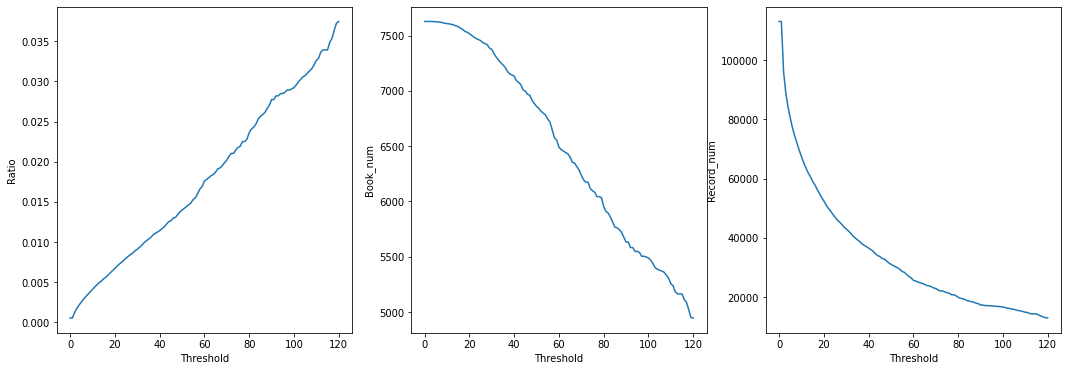

In [249]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(threshold_list, ratio)
plt.xlabel('Threshold')
plt.ylabel('Ratio')

plt.subplot(1, 3, 2)
plt.plot(threshold_list, book_num)
plt.xlabel('Threshold')
plt.ylabel('Book_num')

plt.subplot(1, 3, 3)
plt.plot(threshold_list, record_num)
plt.xlabel('Threshold')
plt.ylabel('Record_num')

plt.show()

#### Finally we choose the threshold as 40 (i.e. users with >= 40 reviews will be kept)
- Improve the sparsity to 1.14% known data (0.05% previously)

In [250]:
threshold = 40

reviewer_id = reviewer_book_count[reviewer_book_count['Uid'] >= threshold].index.get_level_values('UserID').to_list()
reviewer_df = df_reviews_modified[(df_reviews_modified['UserID'].isin(reviewer_id))]
    
total = len(reviewer_id) * len(reviewer_df['Uid'].unique())  # total ratings needed
print("The total reviewer number is: ", len(reviewer_id))
print("The total book number is: ", len(reviewer_df['Uid'].unique()))

records = len(reviewer_df)
print('')
print("The total number of ratings needed are: ", total)
print("The known records are: ", len(reviewer_df))
print("The rating entries need to be estimated are: ", total - len(reviewer_df))

ratio = records / total
print('')
print("The ratio of known data is: %.2f" % (ratio * 100) + '%')

The total reviewer number is:  449
The total book number is:  7133

The total number of ratings needed are:  3202717
The known records are:  36555
The rating entries need to be estimated are:  3166162

The ratio of known data is: 1.14%


In [251]:
# reset index
reviewer_df  = reviewer_df.reset_index(drop=True)

# store for recommendation models
reviewer_df.to_csv('./Datasets/Rec_models_datasets/User_interaction.csv', index=False)

#### Correspondingly we keep only those books are selected

In [252]:
df_info_model = pd.read_csv('./Datasets/Basic_datasets/Book_info_model.csv')

In [253]:
book_selected_uid = reviewer_df['Uid'].unique()
selected_book = df_info_model[df_info_model['Uid'].isin(book_selected_uid)].reset_index(drop=True)

# keep only the selected books
selected_book.to_csv('./Datasets/Rec_models_datasets/Selected_book_info.csv', index=False)

---

## Part 2) &nbsp; Recommendation Models

**<u>Goal</u>**:  Accurately recommend to users unread books that match their reading preferences. 
- Tasks: our models will predict users’ ratings for their unread books and then recommend (predicted) high-rating books to them.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import random

import warnings
warnings.filterwarnings("ignore")

#### Load book data & user reviews data

In [84]:
books_selected = pd.read_csv('./Datasets/Rec_models_datasets/Selected_book_info.csv')
books_selected.head(5)

Uid                                              Title  \
0  13642600  A Splash of Red The Life and Art of Horace Pippin   
1    137933  After the End of Art Contemporary Art and the ...   
2     52374            Against Interpretation and Other Essays   
3    140987             Air Guitar Essays on Art and Democracy   
4     51245                                    Amphigorey Also   

                                              Genres           Author  Rating  \
0  ['picture-books', 'biography', 'art', 'nonfict...       Jen Bryant    3.87   
1  ['art', 'philosophy', 'nonfiction', 'art-histo...  Arthur C. Danto    4.03   
2  ['essays', 'nonfiction', 'philosophy', 'art', ...     Susan Sontag    4.13   
3  ['art', 'nonfiction', 'essays', 'music', 'crit...      Dave Hickey    4.08   
4  ['art', 'humor', 'graphic-novels', 'comics', '...     Edward Gorey    4.40   

      Publish_Date  Page_Num  \
0  January 8, 2013        34   
1  January 1, 1997       264   
2  January 1, 1966       312   
3   August 2, 1997       208   
4  January 1, 1983       256   

                                               Award  \
0  ['schneider_family_book_award', 'vermonts_pict...   
1                                             ['no']   
2                   ['national_book_award_finalist']   
3                                             ['no']   
4                                             ['no']   

                                         Description  \
0  As a child in the late 1800s, Horace Pippin lo...   
1  Over a decade ago, Arthur Danto announced that...   
2  Against Interpretation was Susan Sontag's firs...   
3  The 23 essays (or "love songs") that make up t...   
4  Contents: The Utter Zoo, The Blue Aspic, The E...   

                                         Author_Desc  ...  AddedShelf  ToRead  \
0  Jen Bryant (Jennifer Fisher Bryant) writes pic...  ...        8832    2979   
1  Arthur C. Danto was Johnsonian Professor Emeri...  ...        3176    1946   
2  Susan Sontag was born in New York City on Janu...  ...       38314   26588   
3  David Hickey (born circa 1939) is an American ...  ...        5670    2929   
4  Born in Chicago, Gorey came from a colourful f...  ...        7502    1238   

   added_median  ratings_median  reviews_median  to-read_median  added_IQR  \
0           0.0             0.0             0.0             0.0       1.00   
1           1.0             0.0             0.0             0.0       1.00   
2          19.0             2.0             0.0            14.0       9.75   
3           1.0             0.0             0.0             0.0       1.00   
4           1.0             0.0             0.0             0.0       1.00   

   ratings_IQR  reviews_IQR  to-read_IQR  
0          0.0          0.0         0.00  
1          0.0          0.0         1.00  
2          2.0          0.0         7.75  
3          0.0          0.0         1.00  
4          1.0          0.0         1.00  

[5 rows x 30 columns]

In [114]:
from ast import literal_eval

# Turn 'list-like' string data into lists
books_selected['Genres'] = books_selected['Genres'].apply(lambda x: literal_eval(x) if "[" in x else x)
books_selected['Award'] = books_selected['Award'].apply(lambda x: literal_eval(x) if "[" in x else x)

In [10]:
interactions_df = pd.read_csv('./Datasets/Rec_models_datasets/User_interaction.csv')
interactions_df.head(5)

Uid                                              Title  UserID  \
0  13642600  A Splash of Red The Life and Art of Horace Pippin     192   
1  13642600  A Splash of Red The Life and Art of Horace Pippin   17464   
2    137933  After the End of Art Contemporary Art and the ...   17298   
3    137933  After the End of Art Contemporary Art and the ...   13002   
4     52374            Against Interpretation and Other Essays   17298   

   Reviewer  Review_Rating  N_Review  N_Follower        Review_Date  \
0   Abigail              4      7086         173  February 20, 2021   
1  Michelle              4       301          38      July 10, 2013   
2   Michael              5       718         969  November 14, 2007   
3      Kate              5       396         316    January 7, 2008   
4   Michael              4       718         969     March 16, 2020   

                                             Content  N_Likes  N_Comments  
0  Author Jen Bryant and illustrator Melissa Swee...        3           2  
1  Audience: PrimaryGenre: Non-Fiction/Informatio...        3           0  
2  As I recall, a great book despite my predilect...        1           1  
3  Changed entirely how I think about art. It sta...        1           0  
4  A wide-ranging debut collection of essays on a...       67           2

#### Train & test split

In [12]:
from sklearn.model_selection import train_test_split

interactions_train_df, interactions_test_df = train_test_split(interactions_df,
                                   stratify=interactions_df['UserID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 29249
# interactions on Test set: 7313


In [13]:
# Indexing by 'UserID' to speed up the searches during evaluation

interactions_full_indexed_df = interactions_df.set_index('UserID')
interactions_train_indexed_df = interactions_train_df.set_index('UserID')
interactions_test_indexed_df = interactions_test_df.set_index('UserID')

#### Evaluation - Top-N accuracy metrics

We use the **Top-N accuracy metrics** to evaluate our recommendation models' performance:
- Accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set 

**<u>Pseudo code</u>**:
* For each user:
    * For each item the user has interacted in test set:
        * Sample 100 other items the user has **never interacted**;
        * Recommendation model produces a ranked list of items, from a set composed 1 interacted item and other 100 non-interacted items;
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the ***global*** Top-N accuracy metrics

Here we use **Recall@N**: whether the interacted item is among the top N items (*hit*) in the ranked list of 101 recommendations for a user
- **Metrics**: Recall@5 and Recall@10
- E.g. Recall@5: For one user, if we have 100 randomly selected books, the percentage of the interacted books in the test set will be ranked among the top 5 books by the model

In [31]:
# Get all bookIDs that the given user has interacted with 

def get_items_interacted(person_id, interactions_df):
    
    interacted_items = interactions_df.loc[person_id]['Uid']  # interacted (books') Uids
    
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [33]:
# number of non-interacted items to be combined together for test
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(books_selected['Uid'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        
        # Supress depreciation warning. random.sample will lose support for Sets, 
        # should be convereted to a list or tuple instead
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            non_interacted_items_sample = random.sample(non_interacted_items, sample_size) 
        
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['Uid']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['Uid'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['Uid'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted 
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item 
            # or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['Uid'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Uid'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        # print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            
            people_metrics.append(person_metrics) # append into a complete list

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        # Global metrics for all users
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10} 
        
        return global_metrics, detailed_results_df

In [34]:
model_evaluator = ModelEvaluator()  

### 2.1 &nbsp; Popularity Model (Baseline)

This model is not actually personalized - it simply recommends to a user ***the most popular items that the user has not previously consumed***. 
- As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people;

- But the main objective of a recommender system is to leverage the ***long-tail items*** to the users with very specific interests, which goes far beyond this simple technique. So we will use this model as a **baseline**.

In [35]:
# Computes the most popular items
item_popularity_df = interactions_df.groupby('Uid')['Review_Rating'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

Uid  Review_Rating
0  36576608             87
1    464260             73
2     11588             71
3  17899948             71
4  53799686             69
5     96358             69
6     18386             68
7      7126             68
8      5907             67
9  36373463             67

In [36]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['Uid'].isin(items_to_ignore)] \
                               .sort_values('Review_Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Uid', right_on = 'Uid')[['Review_Rating', 'Uid', 'Title']]

        return recommendations_df

#### Initialize an instance for Popularity model

In [37]:
popularity_model = PopularityRecommender(item_popularity_df, books_selected)

In [38]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
448 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.12457267879119377, 'recall@10': 0.2261725693969643}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
76             20             33                76  0.263158   0.434211   
40             14             26                70  0.200000   0.371429   
21              9             24                69  0.130435   0.347826   
7              10             20                63  0.158730   0.317460   
92             15             26                63  0.238095   0.412698   
45             12             22                62  0.193548   0.354839   
193            21             30                62  0.338710   0.483871   
57             14             16                61  0.229508   0.262295   
287            21             31                60  0.350000   0.516667   
27             19             30                56  0.339286   0.535714   

     _person_id  
76        15602  
40        17161  
21         2557  
7          1863  
92         7740  
45        26336  
193       22026  
57          421  
287       16300  
27        16765

### 2.2 &nbsp; Content-based Filtering

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend ***similar items***. 
- It builds ***users' profiles (tastes)*** depending only on the user previous choices, making this method robust to avoid the *cold-start* problem.

Here we are using a very popular technique in information retrieval (search engines) named [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):
- This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures ***how relevant a given word is for a book***;
- As all items will be represented in the same [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model), we will compute ***cosine similarity*** between books.

In [ ]:
import scipy
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics.pairwise import cosine_similarity

#### Check NaN values in `Description`

In [87]:
if books_selected['Description'].isnull().any():
    print("There is at least one NaN value in the 'Description' column.")
else:
    print("There are no NaN values in the 'Description' column.")

There is at least one NaN value in the 'Description' column.


#### To cover these missing book descriptions, we choose to use each book's  `Title` + `Genres` + `Description`as its textual information `BookText` for constructing the words' vector space

In [115]:
for index, row in books_selected.iterrows():
    genre = ' '.join([str(i) for i in row['Genres']])
    
    book_desc = row['Description']
#     author_desc = row['Author_Desc']
    if isinstance(book_desc, float):
        text  = row['Title'] + genre
    else:
        text = row['Title'] + genre + book_desc
    
    # replace missing 'Description'
    books_selected.loc[index, 'BookText'] = text

#### Train word vectors based on book texts data

In [122]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Stopwords (words with no semantics) from English
stopwords_list = stopwords.words('english') + ['book', 'books']

# Trains a model whose vectors size is 5000, composed by the main unigrams 
# and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

In [123]:
# book Uids
item_ids = books_selected['Uid'].tolist()

# vectorize book description texts
tfidf_matrix = vectorizer.fit_transform(books_selected['BookText'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<7133x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 484277 stored elements in Compressed Sparse Row format>

#### Obtain the word vector representation of a book in the same feature space as the user profiles (i.e. TF-IDF matrix)
- Take all the book files the user has interacted with and average them weighted by user's `Review_Rating`

In [108]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['Uid'])
    
    user_item_strengths = np.array(interactions_person_df['Review_Rating']).reshape(-1,1)
    
    # Weighted average of item profiles by the interactions strength, and normalized
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) \ 
                                                                            / np.sum(user_item_strengths)
    user_profile_norm = normalize(user_item_strengths_weighted_avg)
    
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['Uid'] \
                                                   .isin(books_selected['Uid'])].set_index('UserID')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [220]:
user_profiles = build_users_profiles()

#### We take a look at a user profile example whose name is 'Abigail' (UserID = 192)
- The value in each position represents how relevant is a token (unigram or bigram) for the user named 'Abigail';
- It shows that she is very interested in reading books about ***children***: 
    - Some keywords like ***bear, cat, little*** appear frequently in children's books. 
    - Also note that ***Dr. Seuss*** is a famous writer for children's literatures 

In [225]:
aprofile = user_profiles[192]

print(aprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, user_profiles[192].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


token  relevance
0           children   0.422296
1           dr seuss   0.169196
2              seuss   0.169196
3   children fiction   0.168590
4            animals   0.166772
5            picture   0.157434
6               bear   0.154855
7            fiction   0.145833
8   fiction classics   0.124478
9                 dr   0.123242
10          classics   0.123204
11               cat   0.114586
12            little   0.114381
13               new   0.106283
14               hat   0.095753
15             young   0.094332
16             humor   0.094149
17   fiction animals   0.090396
18   picture fiction   0.089813
19              food   0.088952

In [102]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        # Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        
        # Gets the top similar items & sort by similarity
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['Uid', 'Review_Rating']).head(topn)
        
        # If verbose is set to True, then the method returns a DataFrame that includes additional information 
        # about the recommended items, such as their title, URL, and language. 
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Uid', 
                                                          right_on = 'Uid')[['Review_Rating', 'Uid', 'Title']]


        return recommendations_df

In [126]:
content_based_recommender_model = ContentBasedRecommender(books_selected)

In [127]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
448 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.3638725557226856, 'recall@10': 0.4869410638588814}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
76             32             41                76  0.421053   0.539474   
40             21             34                70  0.300000   0.485714   
21             17             26                69  0.246377   0.376812   
7              33             36                63  0.523810   0.571429   
92              5             16                63  0.079365   0.253968   
45             19             26                62  0.306452   0.419355   
193            17             27                62  0.274194   0.435484   
57              7             14                61  0.114754   0.229508   
287            36             40                60  0.600000   0.666667   
27             12             15                56  0.214286   0.267857   

     _person_id  
76        15602  
40        17161  
21         2557  
7          1863  
92         7740  
45        26336  
193       22026  
57          421  
287       16300  
27        16765

Our content-based filtering model provides personalized recommendations with a **Recall@5 ≈ 0.3639**, indicating that around 36% of the items that the user interacted with in the test set were included in the top-5 recommended items generated by the model from a list of 100 random items. Furthermore, the **Recall@10 ≈ 0.4869**. This is a great improvement from baseline, partially proves the power of this technique.

### 2.3 &nbsp; Collaborative Filtering model

#### We use latent factor model (model-based) for collaborative filtering:
- Compress user-item matrix into a **low-dimensional** representation in terms of latent factors, solving sparsity problem;
- Here we a use popular latent factor model named [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). 

#### <u>Singular Value Decomposition</u>:
$$M_{m \times n} = U_{m \times m} * \Sigma_{m \times n} * V^T_{n \times n} \ \ (Full \ SVD)$$

However, we can choose **the number of latent factors $k$** to factor the user-item matrix and *approximate* original matrix using the following formula:
$$M_{m \times n} \approx U_{m \times k} * \Sigma_{k \times k} * V^T_{k \times n} \ \ (Thin \ SVD)$$

- The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. 
- But if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.
- We will loop over a potential space to find the **best** number of factors $k_{optimal}$

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#### Matrix Factorization

In [141]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='UserID', 
                                                          columns='Uid', 
                                                          values='Review_Rating').fillna(0)

users_items_pivot_matrix_df.head(10)

Uid     1         2         5         6         11        13        21        \
UserID                                                                         
17           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
87           0.0       0.0       0.0       0.0       0.0       0.0       0.0   
192          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
308          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
330          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
383          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
421          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
486          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
523          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
612          0.0       0.0       0.0       0.0       4.0       0.0       0.0   

Uid     22        24        25        ...  61330005  61865476  62053325  \
UserID                                ...                                 
17           0.0       0.0       0.0  ...       0.0       0.0       0.0   
87           0.0       0.0       0.0  ...       0.0       0.0       0.0   
192          0.0       0.0       0.0  ...       0.0       0.0       0.0   
308          0.0       0.0       0.0  ...       0.0       0.0       0.0   
330          0.0       0.0       0.0  ...       0.0       0.0       0.0   
383          0.0       0.0       0.0  ...       0.0       0.0       0.0   
421          0.0       0.0       0.0  ...       0.0       0.0       0.0   
486          0.0       0.0       0.0  ...       0.0       0.0       0.0   
523          0.0       0.0       0.0  ...       0.0       0.0       0.0   
612          0.0       0.0       0.0  ...       0.0       0.0       0.0   

Uid     62296528  62357989  62404966  62967897  63221207  75275383  75953403  
UserID                                                                        
17           0.0       0.0       0.0       0.0       0.0       0.0       0.0  
87           0.0       0.0       0.0       0.0       0.0       0.0       0.0  
192          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
308          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
330          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
383          0.0       4.0       0.0       0.0       0.0       0.0       0.0  
421          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
486          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
523          0.0       0.0       0.0       0.0       0.0       0.0       0.0  
612          0.0       0.0       0.0       0.0       0.0       0.0       0.0  

[10 rows x 6907 columns]

In [142]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [143]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[17, 87, 192, 308, 330, 383, 421, 486, 523, 612]

In [144]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<449x6907 sparse matrix of type '<class 'numpy.float64'>'
	with 29244 stored elements in Compressed Sparse Row format>

#### Here we first set number of factors $k = 40$, representing the number of book genres

In [226]:
# The number of factors to factor the user-item matrix (use the number of genres)
NUMBER_OF_FACTORS_MF = 40

# Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma) # diagonize

In [227]:
U.shape, sigma.shape, Vt.shape

((449, 40), (40, 40), (40, 6907))

#### After the factorization, we try to reconstruct the original matrix by multiplying its factors. 
- No sparsity any more. It generates predictions for items the user has not interacted with, which we will exploit for recommendations.

In [151]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.02292273,  0.01838176,  0.0042864 , ...,  0.01090701,
         0.05341585,  0.01885435],
       [-0.03654072, -0.02313435, -0.03319799, ...,  0.02337009,
        -0.00532303, -0.00283612],
       [ 0.00239874, -0.01840318, -0.02263362, ...,  0.00563758,
         0.11668636, -0.05929882],
       ...,
       [-0.02380071, -0.01779677, -0.01164514, ..., -0.00719634,
         0.01912133,  0.64562998],
       [ 0.10246305,  0.02996917,  0.07688153, ...,  0.15951745,
         0.38916266, -0.06106651],
       [ 0.0035282 ,  0.09884057,  0.13012081, ...,  0.14979794,
         0.49248323,  0.28502441]])

#### Normalize the ratings
$$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

In [152]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / \
                                    (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [153]:
# Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

17        87        192       308       330       383       421    \
Uid                                                                         
1    0.209621  0.202702  0.207233  0.256061  0.154096  0.200324  0.202197   
2    0.209092  0.204262  0.204813  0.216671  0.184733  0.207697  0.195703   
5    0.207452  0.203091  0.204320  0.196924  0.180002  0.208463  0.226422   
6    0.206838  0.203575  0.202876  0.165002  0.172763  0.195258  0.213597   
11   0.202818  0.206896  0.200204  0.187011  0.227901  0.224145  0.214796   
13   0.207045  0.206528  0.206573  0.206293  0.211204  0.206923  0.215997   
21   0.207602  0.219221  0.200512  0.258154  0.170454  0.203612  0.238084   
22   0.207662  0.209752  0.204168  0.205712  0.185924  0.204183  0.196128   
24   0.202855  0.212751  0.202912  0.199510  0.233671  0.197231  0.196826   
25   0.204601  0.213617  0.210699  0.206744  0.211300  0.201049  0.201495   

        486       523       612    ...     26672     26764     26788  \
Uid                                ...                                 
1    0.211589  0.209084  0.255863  ...  0.224655  0.219448  0.229545   
2    0.219007  0.212960  0.207962  ...  0.208117  0.209986  0.230314   
5    0.219798  0.214746  0.189833  ...  0.214457  0.186152  0.237972   
6    0.208480  0.208221  0.221522  ...  0.207416  0.211785  0.236875   
11   0.220232  0.204843  0.371452  ...  0.219410  0.227331  0.200532   
13   0.207239  0.207677  0.210887  ...  0.208789  0.210739  0.205920   
21   0.208334  0.204967  0.237605  ...  0.203969  0.177954  0.206309   
22   0.208172  0.206436  0.248826  ...  0.210740  0.195485  0.209730   
24   0.206458  0.208081  0.193236  ...  0.208867  0.204131  0.217123   
25   0.207056  0.208858  0.199133  ...  0.207029  0.196515  0.215327   

        26801     27096     27151     27345     27405     27451     27503  
Uid                                                                        
1    0.301493  0.209850  0.242302  0.204262  0.204185  0.218875  0.207364  
2    0.262698  0.209426  0.208636  0.208310  0.204883  0.210441  0.218454  
5    0.316868  0.210532  0.179926  0.205686  0.205599  0.215899  0.222093  
6    0.364610  0.207490  0.177145  0.201163  0.202751  0.205092  0.191674  
11   0.113028  0.206088  0.203016  0.210633  0.203510  0.208271  0.206851  
13   0.198669  0.207089  0.209443  0.207892  0.207211  0.211631  0.206859  
21   0.227444  0.208700  0.209455  0.213214  0.207694  0.201361  0.211274  
22   0.198870  0.215863  0.211494  0.209671  0.206048  0.205830  0.205874  
24   0.182691  0.204445  0.193305  0.205499  0.205432  0.211035  0.205520  
25   0.193835  0.205658  0.205196  0.210346  0.205884  0.221218  0.212531  

[10 rows x 449 columns]

In [154]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'Review_Rating'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Uid'].isin(items_to_ignore)] \
                               .sort_values('Review_Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Uid', 
                                                          right_on = 'Uid')[['Review_Rating', 'Uid', 'title']]


        return recommendations_df

In [156]:
cf_recommender_model = CFRecommender(cf_preds_df, books_selected)

In [157]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
448 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.30488305293393514, 'recall@10': 0.41991519627957874}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
35             25             36                76  0.328947   0.473684   
31             21             26                70  0.300000   0.371429   
11             18             27                69  0.260870   0.391304   
168            30             39                63  0.476190   0.619048   
87             18             27                63  0.285714   0.428571   
20             16             20                62  0.258065   0.322581   
156            18             25                62  0.290323   0.403226   
61              5             12                61  0.081967   0.196721   
276            24             33                60  0.400000   0.550000   
83             15             31                56  0.267857   0.553571   

     _person_id  
35        15602  
31        17161  
11         2557  
168        1863  
87         7740  
20        26336  
156       22026  
61          421  
276       16300  
83        16765

Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5 ≈ 30.49%** and **Recall@10 ≈ (41.99%)**.

#### Next we iterate over a list of the number of factors to find the best number of factors $k$

In [ ]:
num_factor = np.linspace(10, 100, 91, dtype='int64')

global_recall_5 = []
global_recall_10 = []

for n in num_factor:
    print("Number of factor is: ", n)
    U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = n)
    sigma = np.diag(sigma)
    
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / \
                                    (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())
    
    cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
    
    # build model
    cf_recommender_model = CFRecommender(cf_preds_df, books_selected)
    cf_global_metrics, _ = model_evaluator.evaluate_model(cf_recommender_model)
    
    global_recall_5.append(cf_global_metrics['recall@5'])
    global_recall_10.append(cf_global_metrics['recall@10'])

#### Plot the metric performance v.s. number of factors (k)

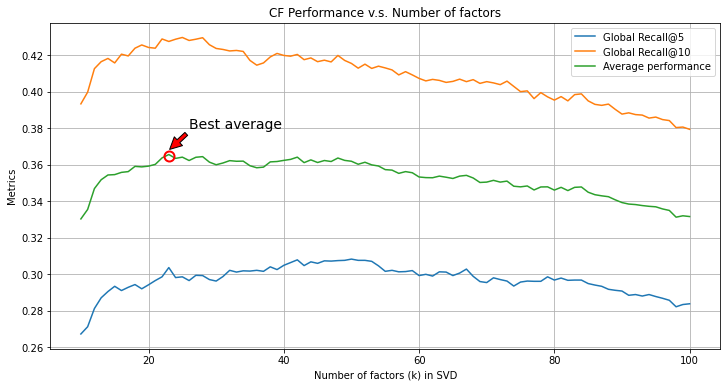

In [216]:
# compute the average of Recall@5 & Recall@10
average_metric = 0.5 * (np.array(global_recall_5) + np.array(global_recall_10))

plt.figure(figsize=(12, 6))
plt.plot(num_factor, global_recall_5, label = 'Global Recall@5')
plt.plot(num_factor, global_recall_10, label = 'Global Recall@10')
plt.plot(num_factor, average_metric, label = 'Average performance')

plt.plot(23, 0.365, 'o', ms=5 * 2, mec='red', mfc='none', mew=2)
plt.annotate('Best average', xy=(23, 0.368), xytext=(26, 0.38), fontsize=14,
            arrowprops=dict(facecolor='red', shrink=0.04))

plt.title('CF Performance v.s. Number of factors')
plt.xlabel('Number of factors (k) in SVD')
plt.ylabel('Metrics')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Find the optimal number of factors based on the average performance of metrics

In [189]:
index = average_metric.argmax()
k_optimal = num_factor[index]

print("The best number of factor k = ", k_optimal)
print("The corresponding Recall@5 = ", global_recall_5[index])
print("The corresponding Recall@10 = ", global_recall_10[index])

The best number of factor k =  23
The corresponding Recall@5 =  0.3036520311858843
The corresponding Recall@10 =  0.4275748871563398


In [191]:
# maximum of two metrics, we can see no large differences with our chosen optimal k
np.max(global_recall_5), np.max(global_recall_10)

(0.30830255778963206, 0.42976337026398576)

#### Re-train the model with optimal k = 23

In [198]:
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = k_optimal)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / \
                                (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()

# build model
cf_recommender_model = CFRecommender(cf_preds_df, books_selected)

print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
448 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3036520311858843, 'recall@10': 0.4275748871563398}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
35             28             40                76  0.368421   0.526316   
31             24             31                70  0.342857   0.442857   
11             22             29                69  0.318841   0.420290   
168            28             35                63  0.444444   0.555556   
87             20             33                63  0.317460   0.523810   
20             21             34                62  0.338710   0.548387   
156            25             29                62  0.403226   0.467742   
61             15             21                61  0.245902   0.344262   
276            23             31                60  0.383333   0.516667   
83             23             29                56  0.410714   0.517857   

     _person_id  
35        15602  
31        17161  
11         2557  
168        1863  
87         7740  
20        26336  
156       22026  
61          421  
276       16300  
83        16765

The optimal collaborative filtering model with $k=23$ demonstrates **Recall@5 ≈ 30.37%** and **Recall@10 ≈ 42.76%**. Also a great improvement from the baseline, but a little bit inferior to our content-based filtering model, possibly due to the great sparsity nature of our dataset. Methods like SVD, which are based on some mathematical theories might not be able to take account of too many 'exceptions' in review ratings in real world.

### 2.4 &nbsp; Hybrid model (Content-based + Collaborative filtering)

- Combine pervious two models: **Content-based filtering** & **Collaborative filtering** together as a hybrid model
- We anticipate these kind of ensembing models will produce a better result than single models

In [199]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight  # weight of content-based filtering
        self.cf_ensemble_weight = cf_ensemble_weight  # weight of collaborative filtering
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'Review_Rating': 'Rating_CB'})
        
        # Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'Review_Rating': 'Rating_CF'})
        
        # Combining the results by Uid
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'Uid', 
                                   right_on = 'Uid').fillna(0.0)
        
        # Computing a hybrid recommendation score based on CF and CB scores 
        recs_df['Rating_Hybrid'] = (recs_df['Rating_CB'] * self.cb_ensemble_weight) \
                                     + (recs_df['Rating_CF'] * self.cf_ensemble_weight)
        
        # Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('Rating_Hybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Uid', 
                                                          right_on = 'Uid')[['Rating_Hybrid', 'Uid', 'Title']]


        return recommendations_df

#### We first simply use the balanced weights 1 : 1 for two models
- You can choose optimal weights by trial and error, or use linear regression to study the optimal weights

In [200]:
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, books_selected,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=1.0)

In [201]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
448 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.515387771850636, 'recall@10': 0.6209820817945562}


hits@5_count  hits@10_count  interacted_count  recall@5  recall@10  \
35             39             46                76  0.513158   0.605263   
31             29             39                70  0.414286   0.557143   
11             25             38                69  0.362319   0.550725   
168            30             37                63  0.476190   0.587302   
87             28             36                63  0.444444   0.571429   
20             31             40                62  0.500000   0.645161   
156            26             32                62  0.419355   0.516129   
61             15             22                61  0.245902   0.360656   
276            30             35                60  0.500000   0.583333   
83             21             32                56  0.375000   0.571429   

     _person_id  
35        15602  
31        17161  
11         2557  
168        1863  
87         7740  
20        26336  
156       22026  
61          421  
276       16300  
83        16765

#### Comparing these models' performance

In [203]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cb_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

recall@5  recall@10
modelName                                   
Popularity               0.124573   0.226173
Content-Based            0.363873   0.486941
Collaborative Filtering  0.303652   0.427575
Hybrid                   0.515388   0.620982

#### Generally we can observe the highest performance in our final hybrid model

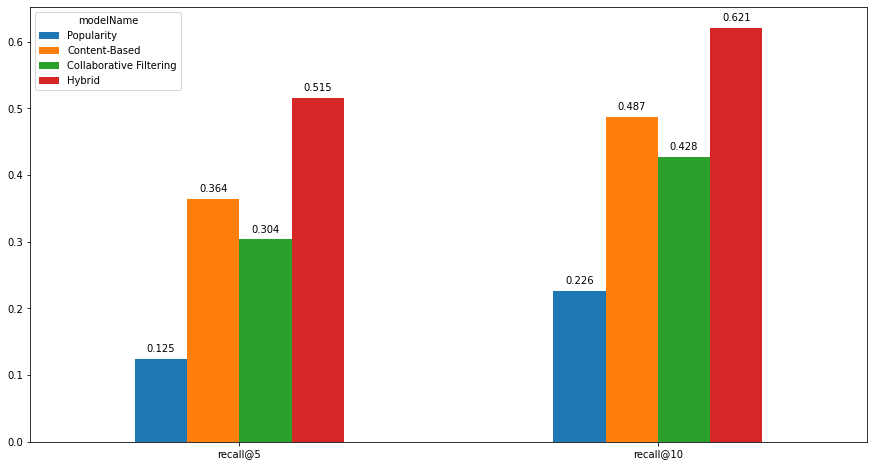

In [208]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8), rot=0)
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#### Though our models demonstrate some impressive results, but we should also pay attention to some potential limitations:
- Here we use **Recall@N** to measure the performance of models, but imagine for some 'extreme' user who is almost always being critical to books (i.e. always posts negative reviews), then our model only learns from the books **relevant** to him and it will be quitely likely to recommend books that might not be the real favor of him.

- This can be extends to the *cold-start* problem for new users, if you only know one rating from this new user and that rating happens to be negative, the recommendation models might not work that well as desired;

- Therefore, currently we use users with at least 40 ratings, but we will try to test our trained models on users with less ratings (eliminated before) to simulate this situation and see how our models work and discuss potential ways to advance performance. 

## Part 3) &nbsp; Natural Language Processing (NLP) models

In this part, we consider some NLP models to prepare for the interaction tools that will be presented in the next module. The main functions are as follows:
- **Tag filtering system**: we want to extract ***tags*** for each book to enable users to filter books & comments by tags
    - **Topic Modeling** (Section 3.2): LDA method
    - **Keywords Extraction** (Section 3.3): TextRank
    - **Keyphrases Extraction** (Section 3.4): Yake!, keyBERT, Rake, etc.
    <br></br>
- **Extractive Summarization** (Section 3.5): Extract top review sentences to serve as a ***summary*** of all reviews of each book
    - Baseline approach
    - Balanced summarization

In [1]:
import pandas as pd
import numpy as np
import os
import re

import warnings
warnings.filterwarnings("ignore")

### 3.1 &nbsp; Texts Pre-processing

Before we start the NLP models, we first conduct some pre-processing on our review content

#### Load the review dataset

In [2]:
df_reviews = pd.read_csv('./Datasets/Basic_datasets/Book_reviews_cleaned.csv')
df_reviews.head(5)

Uid                                              Title  \
0  13642600  A Splash of Red The Life and Art of Horace Pippin   
1  13642600  A Splash of Red The Life and Art of Horace Pippin   
2  13642600  A Splash of Red The Life and Art of Horace Pippin   
3  13642600  A Splash of Red The Life and Art of Horace Pippin   
4  13642600  A Splash of Red The Life and Art of Horace Pippin   

         Reviewer  N_Review  N_Follower  Review_Rating       Review_Date  \
0  Chaplain Walle       380          18              4  January 22, 2023   
1            Lisa       750         131              5  November 7, 2014   
2       Moonkiszt      1922         205              3  January 30, 2022   
3    Cindy Newton       600         127              4     June 20, 2020   
4            Agnė       744          57              3   August 16, 2017   

                                             Content  N_Likes  N_Comments  
0                                       review later       22           0  
1  We enjoyed this beautifully illustrated book a...       11           2  
2  Featured in a grandma reads session.Exactly wh...        7           0  
3  Cute nonfiction picture book over the life of ...        6           0  
4  A Splash of Red: The Life and Art of Horace Pi...        6           9

#### Here for NLP models, we are more interested in the textual reviews left by users: `Content`

In [3]:
reviews = df_reviews[['Uid', 'Content']].copy()
reviews.head(5)

Uid                                            Content
0  13642600                                       review later
1  13642600  We enjoyed this beautifully illustrated book a...
2  13642600  Featured in a grandma reads session.Exactly wh...
3  13642600  Cute nonfiction picture book over the life of ...
4  13642600  A Splash of Red: The Life and Art of Horace Pi...

#### Clean the reviews content

- Lowercase
- Remove punctuation
- Remove digits
- Remove stopwords & frequent but less meaningful words

In [4]:
from string import punctuation

def remove_punctuation(document):
    no_punct_char = []
    for character in document:
        # replace sentence separation punctuation by empty char
        if character in [',', '.', '?', ';']:
            no_punct_char.append(' ')
            continue
            
        if character not in punctuation:
            no_punct_char.append(character)
            
    no_punct = ''.join(no_punct_char)
    
    return no_punct


def remove_digit(document): 
    no_digit = ''.join([character for character in document if not character.isdigit()])
    return no_digit

In [5]:
reviews['Content'] = reviews['Content'].apply(str.lower) # lower case
reviews['Content'] = reviews['Content'].apply(remove_punctuation)
reviews['Content'] = reviews['Content'].apply(remove_digit)

In [6]:
reviews.head()

Uid                                            Content
0  13642600                                       review later
1  13642600  we enjoyed this beautifully illustrated book a...
2  13642600  featured in a grandma reads session exactly wh...
3  13642600  cute nonfiction picture book over the life of ...
4  13642600  a splash of red the life and art of horace pip...

#### Remove stopwords & frequent but less meaningful words

Here we define a **drop probability** (idea from inverse freuqncy used in TD-IDF) to detect high-frequency words as follows:
$$\mathbb{P}_{Drop} = 1 - \frac{t}{frequency}$$

where t is a very small number and  we will drop the word has $\mathbb{P}_{Drop} >= threshold$ to recude model noise and accelerate training 

In [148]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['book', 'one', 'br', 'much', 'story', 'say', 'im', 'ive'])

In [149]:
from collections import Counter
from itertools import chain

def remove_stopwords(reviews):
    return [[word for word in simple_preprocess(str(review)) if word not in stop_words] for review in reviews]

# some words might appear too frequnetly but less meaningful, we also remove them
def remove_frequency_stop_words(reviews):
    t = 1e-5  # t-value
    threshold = 0.8  # threshold
    word_list = list(chain(*reviews)) # use chain() to combine all words
 
    # calculate word frequency
    int_word_counts = Counter(word_list)
    total_count = len(word_list)
    word_freqs = {w: c / total_count for w, c in int_word_counts.items()}
    
    # calculate the drop probability for words
    prob_drop = {w: 1 - np.sqrt(t / f) for w, f in word_freqs.items()}
    
    # if drop probability < threshold, we keep this word for training
    train_words = []
    for i in range(len(reviews)):
        train_words.append([w for w in reviews[i] if prob_drop[w] < threshold])
 
    return train_words

#### We first need to tokenize the reviews to remove stopwords

In [150]:
from gensim.utils import simple_preprocess

def tokenize_reviews(reviews):
    for review in reviews:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(review), deacc=True))

In [151]:
review_list = reviews['Content'].values.tolist()
tokenized_reviews = list(tokenize_reviews(review_list))

In [152]:
tokenized_reviews[1][:20]

['we',
 'enjoyed',
 'this',
 'beautifully',
 'illustrated',
 'book',
 'about',
 'the',
 'life',
 'of',
 'horace',
 'pippin',
 'sometimes',
 'when',
 'we',
 'finish',
 'reading',
 'really',
 'good',
 'book']

In [153]:
# remove stop words & too frequent words
train_words = remove_stopwords(tokenized_reviews)
train_words = remove_frequency_stop_words(train_words)

#### We can observe that, some less meaningful stopwords like: 'we', 'book', 'somtimes', 'this', etc. has been removed

In [154]:
train_words[1][:20]

['beautifully',
 'illustrated',
 'horace',
 'pippin',
 'finish',
 'google',
 'investigate',
 'horace',
 'pippin',
 'artist',
 'admire',
 'perseverance',
 'courage',
 'google',
 'horace',
 'pippin',
 'selftaught',
 'painter',
 'unanimous',
 'eggers']

#### Replace original review texts with stopwords removed and detokenize to sentences

In [158]:
reviews['Content'] = train_words

In [161]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

reviews['Content'] = reviews['Content'].apply(TreebankWordDetokenizer().detokenize)

### 3.2 &nbsp; Topic Modelling: Latent Dirichlet Allocation (LDA)

***Latent Dirichlet Allocation (LDA)*** is an unsupervised learning method that helps us to assign document to a particular set of topics and each topic will be characterized by a particular set of words.
- Package: ***genism*** to implement LDA. 
- Since we have to set the **number of topics** to train the LDA model, we experimented different options from 2 to 10.

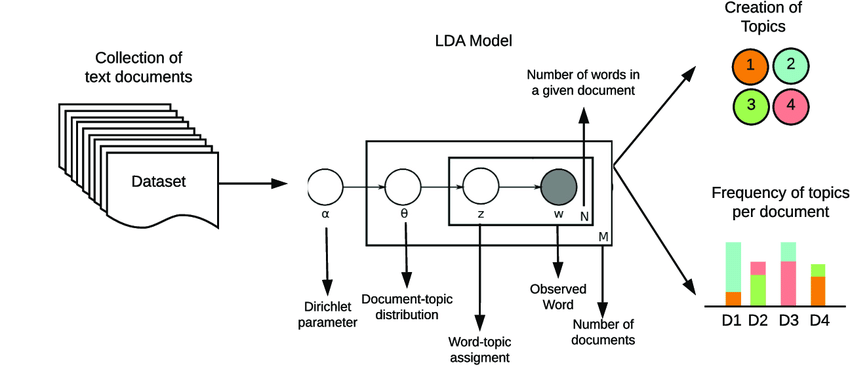

#### To build LDA model, we first need to extact a corpus from our review data
- We first use ***gensim.corpora.Dictionary()***: map each normalized words with an integer ids as a dictionary
- Then we use ***.doc2bow()*** to convert document (a list of words) into the ***bag-of-words*** format: list of (token_id, token_count) 2-tuples.

In [14]:
from gensim import corpora

def corpus_prepare(words_list):
    
    # Create Dictionary
    id2word = corpora.Dictionary(words_list)
    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(word) for word in words_list]
    
    return id2word, corpus

In [15]:
id2word, review_corpus = corpus_prepare(train_words)

#### Build the LDA model
Here by default we set **verbose=False** because the model might need a long time for training, if you want to train by yourself, just turn **verbose=True**

In [7]:
from gensim.models import LdaMulticore
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis

def lda_basic(word_dict, corpus, num_topics, verbose=False):
    
    # Build LDA model
    lda_model = LdaMulticore(corpus=corpus,
                              id2word=word_dict,
                              num_topics=num_topics)
    # Print the keywords in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
  
    # Visualize the topics
    # pyLDAvis.enable_notebook()
    filepath = './output/ldavis_prepared_' + str(num_topics)
    
    # This is a bit time consuming - make verbose = True
    # if you want to execute visualization prep yourself
    if verbose:
        LDAvis_prepared = gensimvis.prepare(topic_model=lda_model, 
                                            corpus=corpus, dictionary=word_dict)
        with open(filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    
    else:
        # load the pre-prepared pyLDAvis data from disk
        with open(filepath, 'rb') as f:
            LDAvis_prepared = pickle.load(f)
    
    # store html result
    pyLDAvis.save_html(LDAvis_prepared, './output/ldavis_content_' + str(num_topics) +'.html')

#### This process might be time-consuming, we recommend to directly use our results

In [ ]:
for i in range(2, 11):
    lda_basic(word_dict=id2word, corpus=review_corpus, num_topics=i, verbose=False)

#### After comparison of different topic numbers, we recognize when topic number = 7, LDA produces the best classification 

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

filepath = './output/ldavis_content_7.html'
display(HTML(filepath))

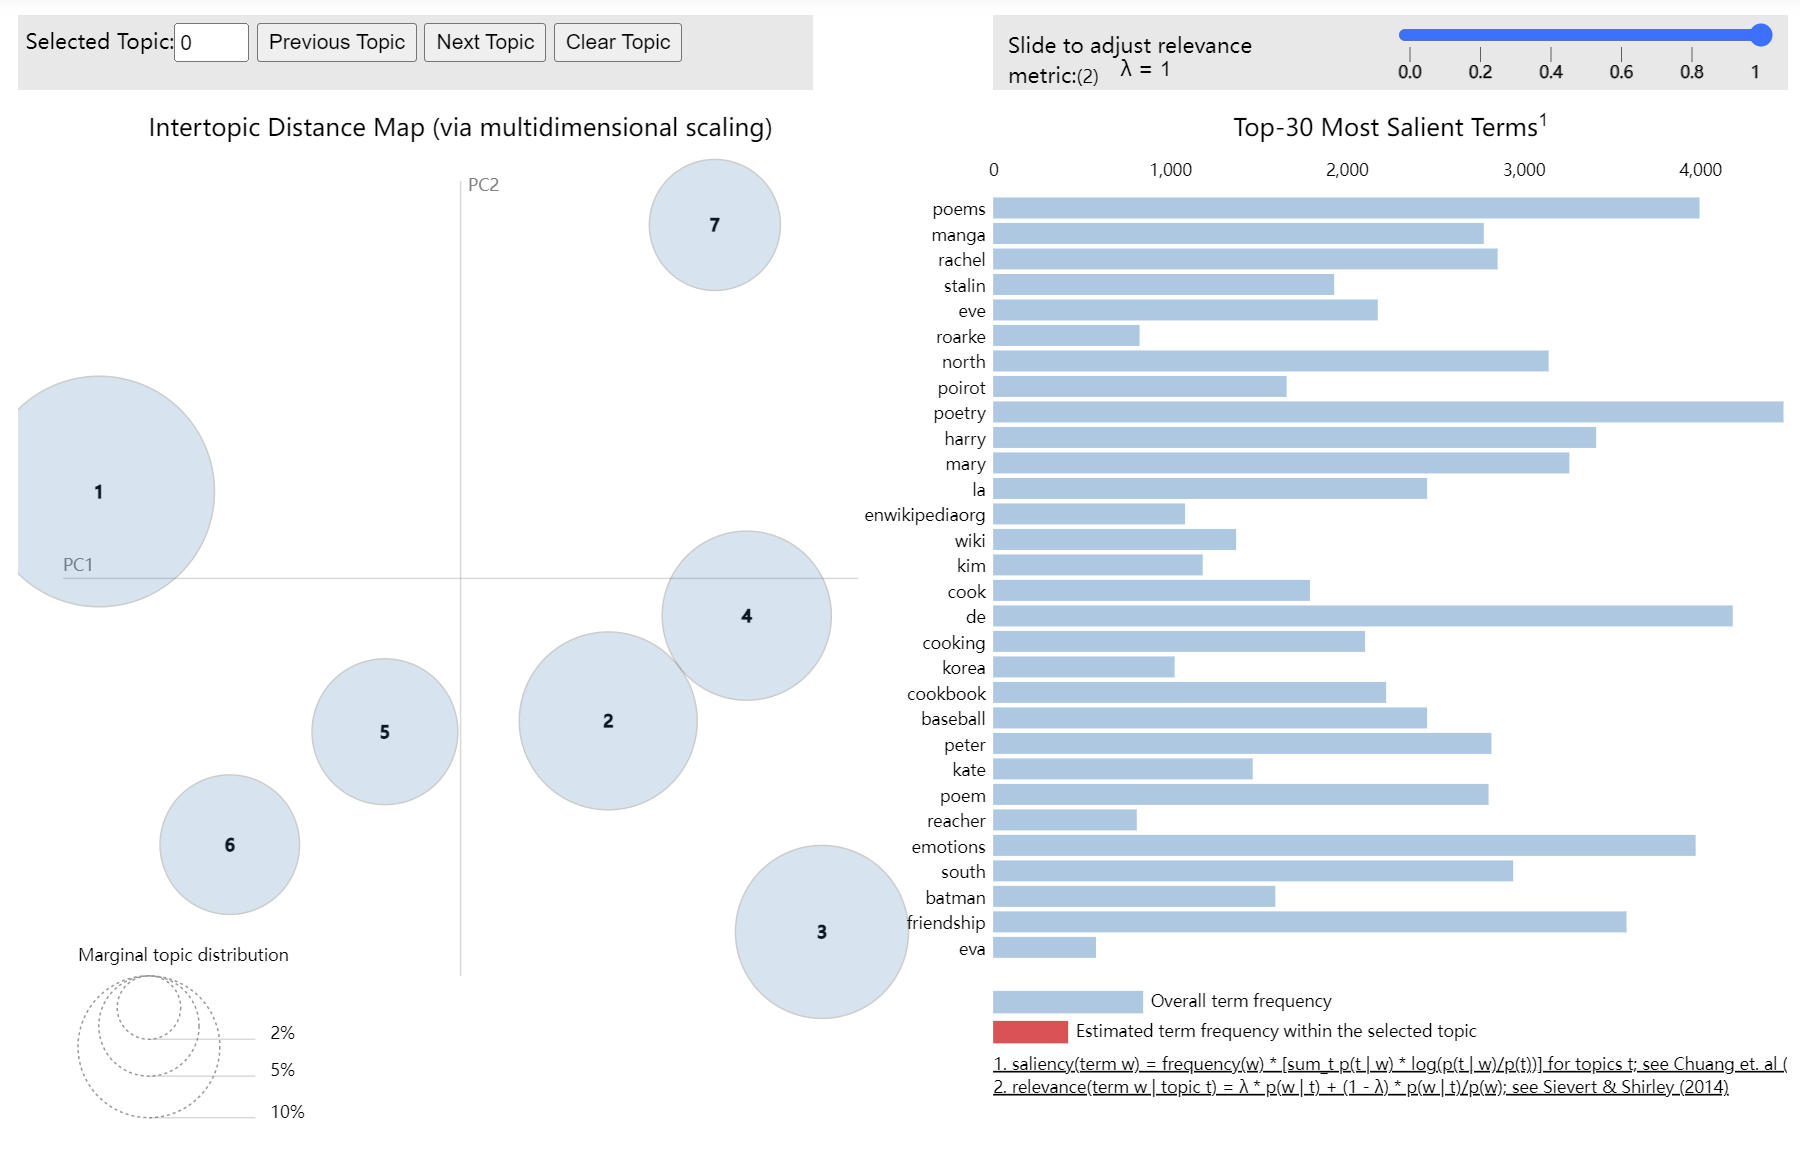

In [38]:
# since HTML object does not display well in notebook conversion, here we use screenshots instead
from IPython.display import Image, display
display(Image('./pictures/LDA_7.png', width=1200, height=1200))

#### However, the problem is that the topic of each cluster is *ambiguous*, thus we cannot decide a specific topic name for each cluster. So we change our mind to extract the keywords for each book instead of all the books together.

### 3.3 &nbsp; Keyword Extraction: *TextRank*

***TextRank*** – is a graph-based ranking model for text processing which can be used to find the **most relevant** sentences or keywords in text
- Idea similar to **PageRank**, a powerful serach engine algorithm
- https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

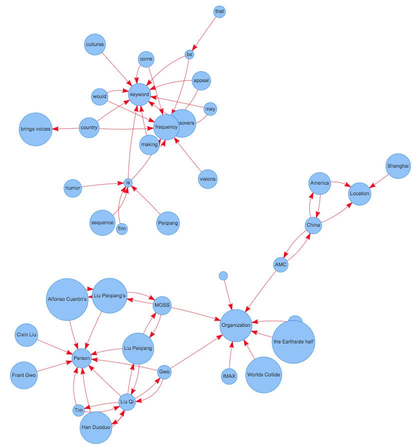

#### First we combine reviews for each book

In [167]:
from tqdm import tqdm

book_dict = {}
for index, row in tqdm(reviews.iterrows()):
    key = row['Uid']
    if key not in book_dict:
        comments = ' '
        comments += row['Content']
        book_dict[key] = comments
    else:
        book_dict[key] += ' ' + row['Content']

df_comments = pd.DataFrame.from_dict(book_dict, orient='index', columns=['Content'])

114034it [00:03, 32956.87it/s]


In [168]:
df_comments.reset_index(inplace=True)
df_comments.rename(columns = {'index':'Uid'}, inplace=True)

df_comments.head()

Uid                                            Content
0  13642600    beautifully illustrated horace pippin finish...
1    470185   strangest months suddenly appear everywhere k...
2    137933   philosophers tend worst theorist artists tend...
3     52374   wideranging debut essays film stimulating rel...
4    140987   introduced dave hickey painting classes profe...

#### Build the *TextRank* model
- Because most of the words in a sentence are not useful to determine the importance, we only consider the words with **NOUN & ADJ** tags
- Each word is a ***node*** in PageRank and if we set the window size as k, the window will like following:
    - $Word \ vector: [w_1, w_2, ..., w_n]$
    - $[w_1, w_2,  ..., w_k], [w_2, w_3, ..., w_{k+1}], ...$ are corresponding windows with size k

In [169]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from string import punctuation

nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
#                 if word in ('.','!','?',',','-','*'):
#                     continue
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
#                 if word in ('.','!','?',',','-','*'):
#                     continue
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        keywords_list = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            if key not in list(string.punctuation):
                keywords_list.append(key)
            if i > number:
                break
        return keywords_list
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'ADJ','VERB'], 
                window_size=4, lower=False, stopwords=list()):
        
        """Main function to analyze text"""
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words

        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

#### We try with example book (Uid = 449128): *Alla Prima: Everything I Know about Painting*
- Window size k = 4, only consider NOUN & ADJ words
- We can see it generally catches important words like: **artist, patinting, canvas, color**, etc.

In [170]:
df_comments.iloc[5, 0]

449128

In [171]:
text = df_comments.iloc[5, 1]

tr4w = TextRank4Keyword()

# we only want adjective & Nouns for tags
tr4w.analyze(text, candidate_pos = ['ADJ','NOUN'], window_size=4, lower=False)
tr4w.get_keywords(10)

['artist',
 'advice',
 'color',
 'schmid',
 'painters',
 'confidence',
 'oil',
 'painting',
 'painter',
 'canvas',
 'artists',
 'composition']

#### We can also get each keyword's weights

In [173]:
[{key: tr4w.node_weight[key]} for key in tr4w.get_keywords(10)]

[{'pippin': 9.081910937634829},
 {'horace': 7.501031593836607},
 {'artist': 3.9051219599946987},
 {'red': 2.845867898168256},
 {'pippins': 2.821484820122126},
 {'illustrations': 2.803523983238113},
 {'artists': 2.8025856402697573},
 {'artwork': 2.4789423374657984},
 {'painter': 2.3143430305118087},
 {'paintings': 2.2721199262405882},
 {'pictures': 2.267219780963017},
 {'notes': 2.0621940091953608}]

#### Next we used *TexRank* to extract 5 keywords of each book and classify each review to that tags if it contains the keyword
- The following process is time-consuming, just use our stored result datasets
    - **book_tags.csv**: 5 keywords tags for each book
    - **review_tags.csv**: keywords this review contains

In [ ]:
# count how many reviews each book has
reviews_count = reviews.groupby(['Uid'], sort=False)['Uid'].count()

# add column 'Tags' if this review contains the keyword
reviews['Tags'] = [[] for _ in range(len(reviews))]
df_comments['Tags'] = [[] for _ in range(len(df_comments))]

num = 0 # the number of reviews we have classified
for i in tqdm(range(df_comments.shape[0])):
    print("The %d-th book" % i)
    text = df_comments.iloc[i, 1] # loop over each book
    
    # get 5 keywords 
    tr4w = TextRank4Keyword()
    tr4w.analyze(text, candidate_pos = ['ADJ', 'NOUN'], window_size=4, lower=False)    
    keyword_list = tr4w.get_keywords(5)
    
    # for each book, store their keywords from reviews
    df_comments['Tags'][i] = keyword_list
    
    # for each review, assign their tags if containing the keyword
    for _ in range(reviews_count.values[i]):
        tag_list = []
        for key in keyword_list:
            if key in reviews.iloc[num,1].split():
                tag_list.append(key)
        
        if not tag_list:
            num += 1
            continue
        print(tag_list)
        reviews['Tags'][num] = tag_list 
        num = num + 1

#### We look at the tag extracted results

In [198]:
# each book's keywords (tags)
df_comments.head(8)

Uid                                            Content  \
0  13642600    beautifully illustrated horace pippin finish...   
1    470185   strangest months suddenly appear everywhere k...   
2    137933   philosophers tend worst theorist artists tend...   
3     52374   wideranging debut essays film stimulating rel...   
4    140987   introduced dave hickey painting classes profe...   
5    449128   painter master artists richard schmid artists...   
6     51245   included utter zoothe blue aspicthe epiplecti...   
7     47559   convey joy edward goreys adore unstrung harp ...   

                                                Tags  
0  [pippin, horace, artist, red, pippins, illustr...  
1  [animals, essays, animal, photography, berger,...  
2  [artists, philosophical, artist, criticism, co...  
3  [sontag, interpretation, essays, criticism, in...  
4  [basketball, essays, hickey, criticism, hickey...  
5  [artist, advice, color, schmid, painters, conf...  
6  [gorey, goreys, legacy, blue, loathsome, utter...  
7  [gorey, hapless, tinies, drawings, gashlycrumb...

In [180]:
# each review's tags (if containing the book's keywords)
reviews.head(8)

Uid                                            Content  \
0  13642600                                                      
1  13642600  beautifully illustrated horace pippin finish g...   
2  13642600  featured grandma reads session splash red hora...   
3  13642600  cute nonfiction artist horace pippin grad clas...   
4  13642600  splash red horace pippin wellresearched pictur...   
5  13642600  jen bryant illustrator melissa collaborated pi...   
6  13642600  audience primarygenre hisher talents splash re...   
7  13642600  aloud bryant obligations frequently artist rep...   

                                               Tags  
0                                                []  
1                          [pippin, horace, artist]  
2                    [pippin, horace, red, artists]  
3                          [pippin, horace, artist]  
4              [pippin, horace, red, illustrations]  
5            [pippin, horace, artist, red, artists]  
6      [pippin, horace, artist, red, illustrations]  
7  [pippin, horace, artist, pippins, illustrations]

In [197]:
# store for use
df_comments.to_csv('./output/book_tags.csv')
reviews.to_csv('./output/review_tags.csv')

### 3.4 &nbsp; Other Trials: Key Phrases

We have also considered using **key phrases** instead of keywords as our tags and we have tried many methods like **Yake!, KeyBERT, Rake** etc. to extract keyphrases, but the phrases we got are not very meaningful as a tag. 

We guess for these methods to get a better result, they might need more effort for tuning model parameters and improve the quality of original textual reviews, both could be time-consuming and no promise for final result. Therefore, we conclude these methods are not very suitable and finally reject them.

In [193]:
# previous tag result from TextRank
df_comments.iloc[3, 2]

['sontag',
 'interpretation',
 'essays',
 'criticism',
 'intellectual',
 'essay',
 'content']

### 3.4.1 &nbsp; YAKE!

YAKE! is a light-weight unsupervised automatic keyword extraction method which rests on text **statistical features** extracted from single documents to select the most important keywords of a text. 

In [185]:
import yake

# take one example
text = df_comments.iloc[3,1]
kw_extractor = yake.KeywordExtractor(top=10, n = 2, stopwords=None)
keywords = kw_extractor.extract_keywords(text)

for kw, v in keywords:
    print("Keyphrase: ",kw, ": score", v)

Keyphrase:  notes camp : score 0.00017788716562028035
Keyphrase:  susan sontag : score 0.0005297176952421673
Keyphrase:  essays susan : score 0.0007224643153954816
Keyphrase:  interpretation essays : score 0.0007676333810896728
Keyphrase:  sontag argues : score 0.0008288173643892819
Keyphrase:  films robert : score 0.0008668558595229885
Keyphrase:  sartres saint : score 0.0008950281626283484
Keyphrase:  saint genet : score 0.0009260733389271714
Keyphrase:  imagination disaster : score 0.0010521084810112312
Keyphrase:  interpretation sontag : score 0.0011256687586082986


According to the result, we could see there are some repetitions and overlaps across the phrases, which makes them hard to convey more diverse meanings and cause information redundancy, which is bad for tags selection.

### 3.4.2 &nbsp; TextRank (Summa)

The core method is the same as TextRank we used before. But this package is not that intelligent since there are so many repetition and it did not catch important information of book reviews.

In [186]:
from summa import keywords

text = df_comments.iloc[3,1]
TR_keywords = keywords.keywords(text, scores=True)
print(TR_keywords[0:10])

[('sontag', 0.4407184696812149), ('sontags', 0.4407184696812149), ('interpretation', 0.2987008422993689), ('critic', 0.2654791090129931), ('criticized', 0.2654791090129931), ('essays film stimulating', 0.18351482641382763), ('interpretations cultured', 0.16760650948307876), ('interpret impoverish', 0.16343202148891145), ('critical takedown', 0.14618324210370381), ('essay notes camp remain', 0.14391607616789773)]


### 3.4.3 &nbsp; KeyBERT

KeyBERT is a simple, easy-to-use keyword extraction algorithm that takes advantage of SBERT embeddings to generate keywords and key phrases from a document that are more similar to the document. 
- First, document embedding (a representation) is generated using the sentences-BERT model;
- Next, the embeddings of words are extracted for N-gram phrases. Computed cosine similarity of each keyphrase to the document;
- The most similar words can then be identified as the words that best describe the entire document and are considered as keywords.

Since BERT model need GPU, we put the result in the comments below.

In [ ]:
from keybert import KeyBERT

text = df_comments.iloc[3,1]
kw_model = KeyBERT(model='all-mpnet-base-v2')
keywords = kw_model.extract_keywords(text, 
                                     keyphrase_ngram_range=(1, 3), 
                                     stop_words='english', 
                                     highlight=False,
                                     top_n=10)

keywords_list= list(dict(keywords).keys())
print(keywords_list)

**keywords_list**: \
['pippin art', 'pippin paintings', 'artist horace', 'pippin artist', 'horace pippin', 'pippin impressionistic', 'painter horace', 'evocative pippin', 'art horace', 'watercolor paintings']

The phrases are not very meaningful as tags because we can see too many common parts between these phrases (e.g. pippin), which might not be able to comprehensively reflect a book's attributes as tags.

### 3.4.4 &nbsp; Rake

Rake is short for ***Rapid Automatic Keyword Extraction*** - a method of extracting keywords from individual documents. It can also be applied to new fields very easily and is very effective in dealing with multiple types of documents, especially text that requires specific grammatical conventions. 

Rake identifies key phrases in a text by analyzing the occurrence of a word and its compatibility with other words in the text (co-occurrence).

In [195]:
from multi_rake import Rake

text = df_comments.iloc[3,1]
rake = Rake()
keywords = rake.apply(text)
print(keywords[:10])

[('quarter petty ephemeral', 9.0), ('packaged sontag', 4.0), ('elevated', 1.0)]


We can see that most phrases are not very summative, the result is far away from satisfying.

### 3.5 &nbsp;  Extract Summary for Reviews on Each Book

After we generate a list of recommended books, we want to help our book readers get a snapshot of what are the major opinions of other people who have reviewed the book. Thus, we aim to provide a summary of reviews on each book to help readers acquire the main ideas efficiently. We utilize <b>extractive summarization</b> method to extract top sentences from all reviews of a certain book and consider the top sentences as the summary. We explored the following two methods to extract the summary:

- **Method 1**: Baseline - LexRank + Sentence-BERT embedding
- **Method 2**: Improvement based on Method 1 to achieve three objectives
    - Maximize Centrality
    - Minimize Redundancy
    - Balance Sentiment

### 3.5.1 &nbsp; Method 1 - Baseline Model

- We firstly use <b>Sentence-BERT</b> to acquire sentence embeddings of each sentence
- Next, we use <b>LexRank</b> to get the graph-based “centrality” of each sentence. The higher the centrality score, the more prominent the sentence is to the whole review.
- Since <b>cosine similarity </b> allows us to approximate how similar two sentence vectors are by simply using the cosine of the angle between the two vectors to quantify how similar two sentences are, we calculate the cosine similarity of sentence embeddings from Sentence-BERT.
- If one sentence is similar to many other sentences in the review, we can claim that it is more central to the review or the "center" of the graph and thus it is more important. 

In summary, for baseline model, we calculate <b>cosine similarity</b> of sentence embeddings from <b>Sentence-BERT</b> and extract <b>5 sentences</b> with the highest centrality scores as the summary.

Note: Our original code files need to run with GPU, thus we only put some code snippets and the results here as demonstration for the report. 

In [ ]:
from sentence_transformers import SentenceTransformer, util
from LexRank import degree_centrality_scores
from nltk.tokenize import sent_tokenize
from textblob import TextBlob

model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

#### Build a pipeline function for generating summary of book reviews

In [ ]:
def extract_summary(Uid, topk=5):

    # select all review sentences of a typical book with selected Uid
    sentences = sent_tokenize(df_comments[df_comments['Uid'] = Uid].Content)
    # we calculate the sentiment score using TextBlob, this measurement will be used as n evaluation metric later
    sentiments = list(map(lambda text: TextBlob(text).sentiment.polarity, sentences))
    doc_sentiment = np.mean(sentiments)

    # Encode each sentence with Sentence-BERT
    sentence_embeddings = model.encode(sentences)
    # Calculate the cosine similarity scores among sentences
    cos_scores = util.cos_sim(sentence_embeddings, sentence_embeddings).numpy()
    # Obtain the centrality scores with LexRank
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
    # We obtain the indexes of the most central sentences
    most_central_sentence_indices = np.argsort(-centrality_scores)
    summary_idxes = list(most_central_sentence_indices[:topk])

    # We use redundancy score as another evaluation metric
    def _compute_redundancy(idx, summary_idxes):
        if not summary_idxes: return 0
        return max([cos_scores[idx][senti] for senti in summary_idxes])

    # Store the outputs
    out_summary = ""
    out_sentiment = ""
    out_centralities = ""
    summary_sentiments = []
    summary_centralities = []
    summary_redundancies = []
    for idx in summary_idxes:
        summary_sentiments.append(sentiments[idx])
        summary_centralities.append(centrality_scores[idx])

        # compute redundancy of the specific sentence to all other sentences in the summary
        summary_idxes.remove(idx)
        redundancy = _compute_redundancy(idx, summary_idxes)
        summary_idxes.append(idx)
        summary_redundancies.append(redundancy)

        out_summary += sentences[idx] + "[SEP]"
        out_sentiment += str(sentiments[idx]) + "[SEP]"
        out_centralities += str(centrality_scores[idx]) + "[SEP]"

    mean_sentiment = np.mean(summary_sentiments)
    mean_centrality = np.mean(summary_centralities)
    mean_redundancy = np.mean(summary_redundancies)

    print(f"{mean_sentiment}, {mean_centrality}, {mean_redundancy}, {doc_sentiment}")

    return out_summary, out_sentiment, out_centralities, mean_sentiment, mean_centrality, mean_redundancy, doc_sentiment

#### Result demonstration

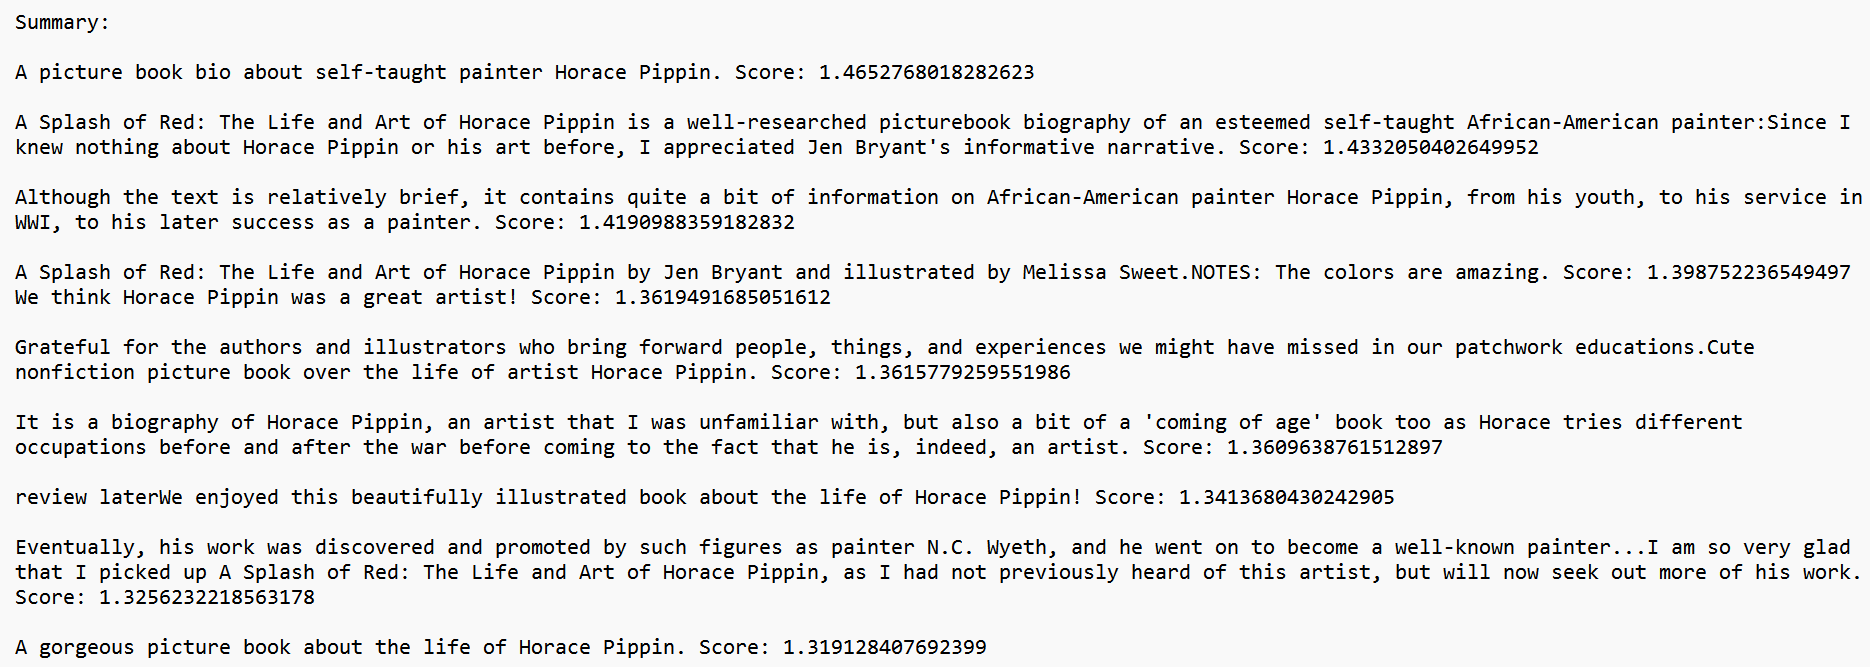

In [201]:
from IPython.display import Image, display
display(Image('./pictures/Baseline_output.png', width=1200, height=1200))

However, after running the baseline model, we noticed some issues. 

- First, there may be <b>different sentiment distribution</b> of extracted summary and original review texts of one book
    - Note: Sentiment scores are calculated using TextBlob Polarity Score (-1: Negative to 1: Positive)
    - For example, we may have mean sentiment of summary as 0.1565 and mean sentiment of original texts as 0.1217
<br></br>
- Second, there may be some <b>redundant information</b> among sentences in extracted summary
    - For example, for two sentences in the summary, they convey similar meanings
        - E.g. `Good book with clear structure!` & `Great book with organized structure!`
    - We want to try avoiding such redundancy and providing more diverse information to end users with the summary

To deal with the issues, we propose a more **balanced** summarization algorithm in method 2.

### 3.5.2 &nbsp; Method 2 - Improvement - Balanced Summarization

We use a greedy algorithm to extract a more balanced summary with <b>three objectives</b>

- **Maximize centrality score** which represents the importance of the sentence
- **Minimize** the difference between the summary sentiment and the overall sentiment of the original review texts
- **Minimize** the redundant information between extracted sentences

The learning objective of the model can be written as:

$$O(s, S, A) = Centrality(s), CosineSimilarity(s, S) - SentimentDifference(S ⋃ {s}, A)$$

where
- $s$ represent the current review sentence, 
- $S$ is the target extracted summary, and 
- $A$ represents all the review texts of that specific book

Essentially, we want to extract a summary with high centrality, low redundancy, and a balanced sentiment. 

The following is the code snippets of our improved algorithm. 

In [ ]:
def extract_summary_balanced(Uid, topk=5):

    """

    :param Uid:
    :param topk:
    :return: out_summary: summary string separated by [SEP]
            out_sentiment: sentiments string separated by [SEP]
            out_centralities: centrality score string separated by [SEP]
            mean_sentiment,
            mean_centrality,
            mean_redundancy,
            doc_sentiment: mean sentiment of original text score
    """

    # select sample review sentences
    sentences = sent_tokenize(df_comments[df_comments['Uid'] = Uid].Content)
    # we calculate the sentiment score using TextBlob, this measurement will be used as n evaluation metric
    sentiments = list(map(lambda text: TextBlob(text).sentiment.polarity, sentences))
    doc_sentiment = np.mean(sentiments)

    # Encode each sentence with Sentence-BERT
    sentence_embeddings = model.encode(sentences)
    # Calculate the cosine similarity scores among sentences
    cos_scores = util.cos_sim(sentence_embeddings, sentence_embeddings).numpy()
    # Obtain the centrality scores with LexRank
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)

    # We use redundancy score as another evaluation metric
    def _compute_redundancy(idx, summary_idxes):
        if not summary_idxes: return 0
        return max([cos_scores[idx][senti] for senti in summary_idxes])

    # We compute the sentiment score difference between the extracted summary and the original review text
    def _sentiment_difference(idx, summary_idxes):
        return abs(doc_sentiment - np.mean([sentiments[idx]] + [sentiments[senti] for senti in summary_idxes]))

    summary_idxes = []
    best_idx = None

    while len(summary_idxes) < topk and best_idx != -1:
        best_idx, best_objective = -1, -1000
        for idx in range(len(sentences)):
            if idx not in summary_idxes:
                redundancy = _compute_redundancy(idx, summary_idxes)
                sentiment_difference = _sentiment_difference(idx, summary_idxes)
                # maximizing centrality while minimizing redundancy and sentiment difference
                objective = centrality_scores[idx] - redundancy - sentiment_difference
                if objective > best_objective:
                    best_idx = idx
                    best_objective = objective
        if best_idx != -1:
            summary_idxes.append(best_idx)

    # Store the outputs
    out_summary = ""
    out_sentiment = ""
    out_centralities = ""
    summary_sentiments = []
    summary_centralities = []
    summary_redundancies = []

    for idx in summary_idxes:
        summary_sentiments.append(sentiments[idx])
        summary_centralities.append(centrality_scores[idx])

        # compute redundancy of the specific sentence to all other sentences in the summary
        summary_idxes.remove(idx)
        redundancy = _compute_redundancy(idx, summary_idxes)
        summary_idxes.append(idx)
        summary_redundancies.append(redundancy)

        out_summary += sentences[idx] + "[SEP]"
        out_sentiment += str(sentiments[idx]) + "[SEP]"
        out_centralities += str(centrality_scores[idx]) + "[SEP]"

    mean_sentiment = np.mean(summary_sentiments)
    mean_centrality = np.mean(summary_centralities)
    mean_redundancy = np.mean(summary_redundancies)

    print(f"{mean_sentiment}, {mean_centrality}, {mean_redundancy}, {doc_sentiment}")

    return out_summary, out_sentiment, out_centralities, mean_sentiment, mean_centrality, mean_redundancy, doc_sentiment

### 3.5.3 &nbsp; Result & Evaluation

Due to lack of gold summaries, we use <b>three metrics (Centrality, Sentiment Differences, and Redundancy) </b> of extracting the top 5 central sentences

- <b>Centrality</b>: Average centrality of summary sentences $->$ (Higher the better)
- <b>Sentiment Difference</b>: |mean of original text  - mean of summary (sentiment)| $->$ (Lower the better)
- <b>Redundancy</b>: Average cosine similarity among summary sentences $->$ (Lower the better)


In [204]:
# Read result CSVs
summ_baseline = pd.read_csv('./output/summ-baseline-out.csv').iloc[:, 1:]  # baseline model
summ_balanced = pd.read_csv('./output/summ-balance-out.csv').iloc[:, 1:] # balanced model

#### We define an evaluation function to compute the above 3 metrics

In [230]:
def evaluation(name, stats_df):
    stats_df.replace(np.inf, np.nan, inplace=True) # replace 'inf' by 'NaN'
    stats_df.dropna(axis=0, how='any', inplace=True) # then drop all NaNs
    mean_df = stats_df.describe().loc['mean', :]
    
    print(name + " model metrics:")
    print("Centrality: ", mean_df['Mean_centrality'])
    print("Sentiment Difference: ", np.abs(mean_df['Mean_sentiment'] - mean_df['doc_sentiment']))
    print("Redundancy: ", mean_df['Mean_redundancy'])
    
    pass

In [231]:
evaluation("Baseline", summ_baseline.iloc[:, -4:])

Baseline model metrics:
Centrality:  1.457832593624464
Sentiment Difference:  0.034905608279972744
Redundancy:  0.65922499530985


In [233]:
evaluation("Balanced", summ_balanced.iloc[:, -4:])

Balanced model metrics:
Centrality:  1.407710446431976
Sentiment Difference:  0.006182471345803298
Redundancy:  0.5434062235968687


We summarize the metrics for two methods as follows:

|| Baseline      | Balanced Summarization |
|-----------| ----------- | ----------- |
|<b>Centrality</b>| <b>1.4578</b>      | 1.4077       |
|<b>Sentiment Difference</b>| 0.0349   | <b>0.0062</b>      |
|<b>Redundancy</b>| 0.6592  | <b>0.5434</b>     |

We can observe that, though sacrificing minor centrality, our Improvement method (Balanced Summarization Algorithm) achieved <b>lower sentiment difference</b> and <b>lower redundancy</b> than baseline method, generally a good result.

---

### Part 4) &nbsp; Summary & Future plans

In this module, we first conduct some modifications on original datasets based on findings from exploratory data analysis and prepare it into a less sparse form for model part. Then we explore multiple recommendation models with optimizations that produce impressive results. Finally, we employ NLP models to provide more detailed information alongside books recommended to users, playing a role of user interaction tool and effective information extraction.

In the next module, we shall consider the following advancement and plans:
- **Ensemble model**: Currently we have considered several recommendation models and a hybrid one to combine them. Next we prepare to introduce some linear models that take book features & user features into consideration and then build a high-functional ensemble model as our final model;

- **NLP**: We will use NLP models to provide information overview of recommended book with our tags, summarization and sentiment scores. Then integrate models with interactive user interface to help users efficiently acquire information about books recommended to them

- **Interactive User interface**: In the next module, we will present an interactive user interface to play with our recommdendation system. It integrates recommendation models that produce to-read lists for users and use NLP models to provide information overview.